In [1]:
import pandas as pd
import sklearn as skl
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from imageio import mimwrite

from sklearn.preprocessing import (
    StandardScaler, QuantileTransformer)

import cartopy
import cartopy.crs as ccrs

from shapely.geometry import Polygon
from shapely.ops import cascaded_union

from datetime import date

import tensorflow as tf

from scipy.interpolate import (
    UnivariateSpline, LSQUnivariateSpline)

from matplotlib.backends.backend_pdf import PdfPages

import pygam

In [2]:
nytimes_data = pd.read_csv('~/nytimes/covid-19-data/us-counties.csv')

nytimes_data = nytimes_data.iloc[np.where(np.isfinite(nytimes_data[['fips']].values))[0]]

nytimes_data['predecessor_date'] = (
    [date.fromisoformat(x).toordinal() - 1 for x in nytimes_data['date']])

In [3]:
nytimes_data['state_id'] = 1000. * (nytimes_data[['fips']] // 1000)

In [4]:
## From US Census Bureau records
county_reader = cartopy.io.shapereader.Reader('./cb_2018_us_county_500k.shp')
counties = list(county_reader.records())
county_indices = pd.DataFrame({
    'GEOID' : [float(counties[i].attributes['GEOID']) for i in range(len(counties))],
    'index' : [i for i in range(len(counties))]})

In [5]:
with open('./co-est2019-alldata.csv', 'r') as fd:
    a = pd.read_csv('./co-est2019-alldata.csv', encoding='latin1')

all_pops = pd.DataFrame({
    'POP' : a[['POPESTIMATE2019']].values.reshape(-1),
    'fips' : a[['STATE']].values.reshape(-1) * 1000. + a['COUNTY'].values.reshape(-1)
})

state_pops = all_pops[a['COUNTY'].values.reshape(-1) == 0]
county_pops = all_pops[a['COUNTY'].values.reshape(-1) != 0]

In [6]:
extended_county_data = nytimes_data.merge(county_pops, left_on='fips', right_on='fips')

In [7]:
extended_state_data = nytimes_data.merge(state_pops, left_on='state_id', right_on='fips')

In [8]:
extended_county_data['normalized_cases'] = (
    100000 *
    extended_county_data[['cases']].values.reshape(-1) / 
    extended_county_data[['POP']].values.reshape(-1))
extended_county_data['normalized_deaths'] = (
    100000 *
    extended_county_data[['deaths']].values.reshape(-1) / 
    extended_county_data[['POP']].values.reshape(-1))

In [9]:
county_data = extended_county_data.groupby(['state', 'county', 'predecessor_date']).sum()

The state population data in each row gets confused by the fact that we add the state id many times for each data. We have to do this is two steps -- first take the sum for each column, and then replace the state_id and population for each row with the single alue it should have. This cheat is ugly, but it works.

In [10]:
mean_state_data = extended_state_data.groupby(['state', 'predecessor_date']).mean()

In [11]:
state_data = extended_state_data.groupby(['state', 'predecessor_date']).sum()

In [12]:
state_data['state_id'] = mean_state_data['state_id']
state_data['POP'] = mean_state_data['POP']

In [13]:
state_data['normalized_cases'] = (
    100000 * 
    state_data[['cases']].values.reshape(-1) / 
    state_data[['POP']].values.reshape(-1))
state_data['normalized_deaths'] = (
    100000 *
    state_data[['deaths']].values.reshape(-1) / 
    state_data[['POP']].values.reshape(-1))

In [14]:
def build_monotone_spline(x, y, 
                          n_splines=20,
                          spline_order=3, 
                          dist=pygam.distributions.NormalDist(0.01)):
    spl_base = pygam.pygam.GAM(
        pygam.terms.s(0, constraints='monotonic_inc', lam=0.5),
        distribution=dist,
        n_splines=n_splines,
        spline_order=spline_order)
    spl_base.fit(x, y)
        
    ## We use a bit of cleverness here. Since any spline is completely 
    ## determined by the location of its knots and its values at those knots,
    ## we use a standard interpolating spline through those values,
    ## with two differences: we know the actual values of the function at the
    ## two endpoints, so we use those values during training instead of using
    ## the values imputed by the GAM.
    x_spl = np.linspace(np.min(x), np.max(x), 2 * n_splines)
    y_spl = spl_base.predict(x_spl)
    #y_spl[0] = y[0]
    #y_spl[-1] = y[-1]
    
    x_knots = np.linspace(np.min(x), np.max(x), n_splines)
    
    spl = LSQUnivariateSpline(
        x=x_spl,
        y=y_spl,
        t=x_knots[1:-1],
        k=spline_order)
    
    return spl

In [15]:
def build_county_stats_dict():
    county_stats_dict = {}
    for state_name in np.unique(county_data.index.get_level_values(0)):
        print(state_name)
        restricted_county_data = county_data[county_data.index.get_level_values(0) == state_name]
    
        for county_name in np.unique(restricted_county_data.index.get_level_values(1)):
            county_cases = restricted_county_data[restricted_county_data.index.get_level_values(1) == county_name]
        
            if county_cases.shape[0] < 20:
                continue
            
            x = county_cases.index.get_level_values(2).values.reshape(-1)
            y_base = county_cases[['normalized_cases']].cummax().values.reshape(-1)
            if np.unique(y_base).shape[0] == 1:
                continue
                
            y = y_base[1:] - y_base[:-1]
            
            spl = build_monotone_spline(x, y_base)
            
            xs = np.arange(np.min(x) + 1, np.max(x) + 1)
            ys = spl.derivative(1)(xs)
            dydxs = spl.derivative(2)(xs)
            
            base_fips = np.empty([x.shape[0]])
            base_fips[:] = county_cases[['fips']].values.reshape(-1)[0]
            smoothed_fips = np.empty([xs.shape[0]])
            smoothed_fips[:] = county_cases[['fips']].values.reshape(-1)[0]
                
            county_stats_dict[int(county_cases[['fips']].values.reshape(-1)[0])] = (            
                {
                    'base_diffs' : np.vstack((base_fips[1:], x[1:], y)).T, 
                    'smoothed_diffs' : np.vstack((smoothed_fips, xs, ys)).T, 
                    'smoothed_diff_derivs': np.vstack((smoothed_fips, xs, dydxs)).T,
                })
            
    return county_stats_dict

county_stats_dict = build_county_stats_dict()

Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming


In [16]:
base_diffs_array = pd.DataFrame(
    np.vstack([county_stats_dict[fips]['base_diffs'] 
               for fips in list(county_stats_dict.keys())]))
base_diffs_array.columns = ['fips', 'x', 'y']

smoothed_diffs_array = pd.DataFrame(
    np.vstack([county_stats_dict[fips]['smoothed_diffs'] 
               for fips in list(county_stats_dict.keys())]))
smoothed_diffs_array.columns = ['fips', 'xs', 'ys']

smoothed_diff_derivs_array = pd.DataFrame(
    np.vstack([county_stats_dict[fips]['smoothed_diff_derivs'] 
               for fips in list(county_stats_dict.keys())]))
smoothed_diff_derivs_array.columns = ['fips', 'xs', 'dysdxs']

In [17]:
smoothed_diffs_normalizer = lambda x : 0.6 * x
smoothed_diff_derivs_normalizer = lambda x : (1.5 * x + 0.5)

In [18]:
def plot_rate_change_county_cases(result_array, date):
    working_cmap = plt.get_cmap('coolwarm', 16)
    
    restricted_result_array_precursor = (
        result_array[result_array['xs'].values.reshape(-1) == date]).merge(
        county_indices, left_on='fips', right_on='GEOID')
    
    good_rows = (
        np.setdiff1d(
            np.arange(restricted_result_array_precursor.shape[0]),
            np.where(~np.isfinite(restricted_result_array_precursor))[0]))
    
    restricted_result_array = (
        restricted_result_array_precursor.values[good_rows, :])
        
    central_lat = 37.5
    central_lon = -96
    extent = [-120, -70, 23, 50.5]
    central_lon = np.mean(extent[:2])
    central_lat = np.mean(extent[2:])

    fig, ax = plt.subplots(figsize=(24, 12))
    ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
    ax.set_extent(extent)

    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
    ax.add_feature(cartopy.feature.BORDERS)
        
    transformed_scores = (
        smoothed_diff_derivs_normalizer(
            restricted_result_array[:, 2].reshape(-1, 1)))
    
    colors = [
        working_cmap(transformed_scores[i, 0])
        for i in range(restricted_result_array.shape[0])]
    
    ax.add_feature(
        cartopy.feature.ShapelyFeature(
            [counties[int(restricted_result_array[int(i), -1])].geometry 
             for i in range(restricted_result_array.shape[0])], 
            cartopy.crs.PlateCarree(),
            facecolor=colors))    
    ax.add_feature(cartopy.feature.STATES, edgecolor='lightgrey')

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close()
    
    return image

In [19]:
rate_change_county_cases = [
    plot_rate_change_county_cases(smoothed_diff_derivs_array, image_date) 
    for image_date in np.unique(smoothed_diff_derivs_array['xs'].values)
]

In [20]:
mimwrite('./rate_change_county_cases.gif', 
         rate_change_county_cases,
         fps=2,
         subrectangles=True,
         loop=1)

In [21]:
def plot_county_rate_cases(result_array, date):
    working_cmap = plt.get_cmap('Reds', 8)
    
    restricted_result_array_precursor = (
        result_array[result_array['xs'].values.reshape(-1) == date]).merge(
        county_indices, left_on='fips', right_on='GEOID')
    
    good_rows = (
        np.setdiff1d(
            np.arange(restricted_result_array_precursor.shape[0]),
            np.where(~np.isfinite(restricted_result_array_precursor))[0]))
    
    restricted_result_array = (
        restricted_result_array_precursor.values[good_rows, :])
        
    central_lat = 37.5
    central_lon = -96
    extent = [-120, -70, 23, 50.5]
    central_lon = np.mean(extent[:2])
    central_lat = np.mean(extent[2:])

    fig, ax = plt.subplots(figsize=(24, 12))
    ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
    ax.set_extent(extent)

    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
    ax.add_feature(cartopy.feature.BORDERS)
        
    transformed_scores = (
        smoothed_diffs_normalizer(
            restricted_result_array[:, 2].reshape(-1, 1)))
    
    colors = [
        working_cmap(transformed_scores[i, 0])
        for i in range(restricted_result_array.shape[0])]
    
    ax.add_feature(
        cartopy.feature.ShapelyFeature(
            [counties[int(restricted_result_array[int(i), -1])].geometry 
             for i in range(restricted_result_array.shape[0])], 
            cartopy.crs.PlateCarree(),
            facecolor=colors))    
    ax.add_feature(cartopy.feature.STATES, edgecolor='lightgrey')

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close()
    
    return image

In [22]:
rate_county_cases = [
    plot_county_rate_cases(smoothed_diffs_array, image_date) 
    for image_date in np.unique(smoothed_diff_derivs_array['xs'].values)
]

In [23]:
mimwrite('./rate_county_cases.gif', 
         rate_county_cases,
         fps=2,
         subrectangles=True,
         loop=1)

In [24]:
def build_state_stats_dict(target_feature_name):
    state_stats_dict = {}
    for state_name in np.unique(state_data.index.get_level_values(0)):
        restricted_state_data = state_data[state_data.index.get_level_values(0) == state_name]
        state_cases = restricted_state_data[restricted_state_data[[target_feature_name]].values > 0]
        
        if state_cases.shape[0] < 10:
            continue
    
        x = state_cases.index.get_level_values(1).values.reshape(-1)
        y_base = state_cases[[target_feature_name]].cummax().values.reshape(-1)
        y = (y_base[1:] - y_base[:-1])
        
        spl = build_monotone_spline(x, y_base, spline_order=4)
        
        xs = np.arange(np.min(x) + 1, np.max(x) + 1)
        ys_base = spl(xs)
                            
        ys = spl.derivative(1)(xs)
        dydxs = spl.derivative(2)(xs)
        
        state_id = state_cases[['state_id']].values.reshape(-1)[0]
        base_fips = np.empty(y_base.shape[0])
        base_fips[:] = state_id
        base_diff_fips = np.empty([x.shape[0]])
        base_diff_fips[:] = state_id
        smoothed_fips = np.empty([xs.shape[0]])
        smoothed_fips[:] = state_id
        
        state_stats_dict[int(state_id)] = (            
            {
                'state_name' : state_name,
                'base_vals' : np.vstack((base_fips, x, y_base)).T,
                'smoothed_vals' : np.vstack((smoothed_fips, xs, ys_base)).T,
                'base_diffs' : np.vstack((base_diff_fips[1:], x[1:], y)).T, 
                'smoothed_diffs' : np.vstack((smoothed_fips, xs, ys)).T, 
                'smoothed_diff_derivs': np.vstack((smoothed_fips, xs, dydxs)).T,
            })
            
    return state_stats_dict

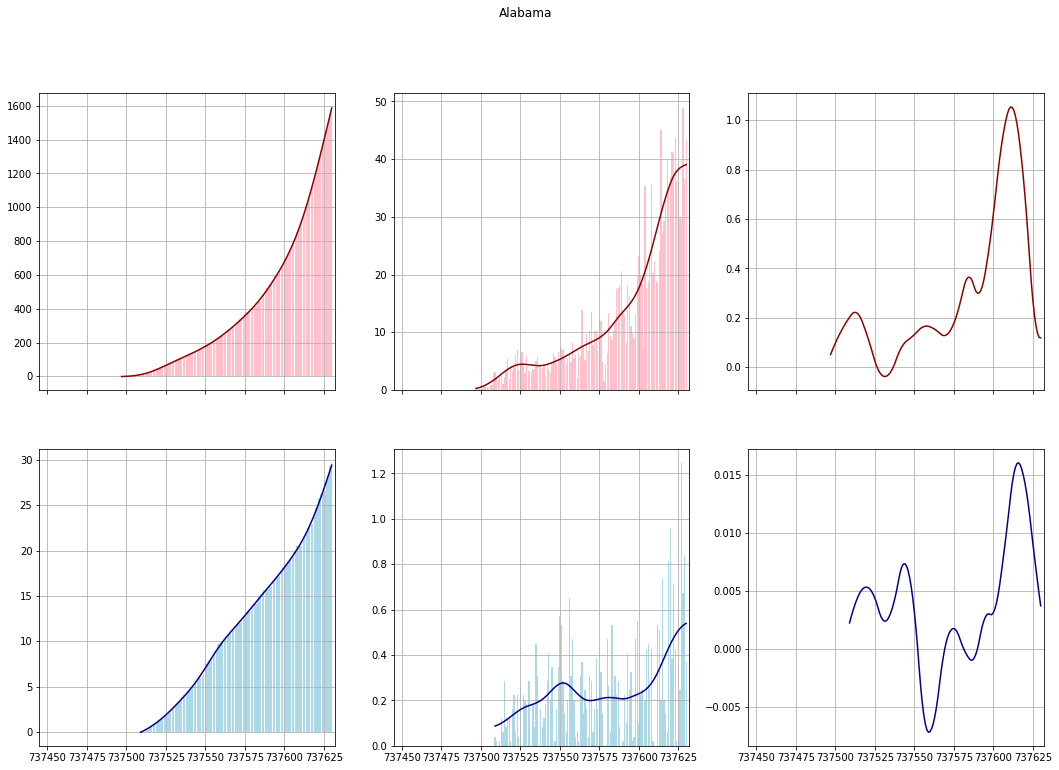

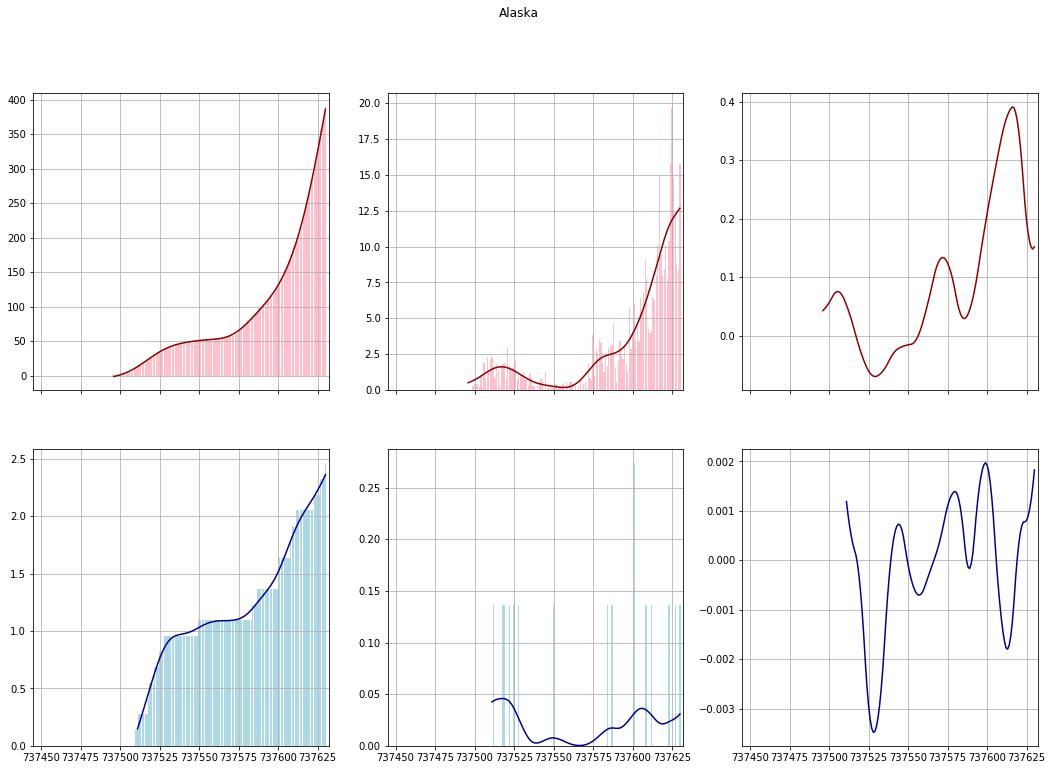

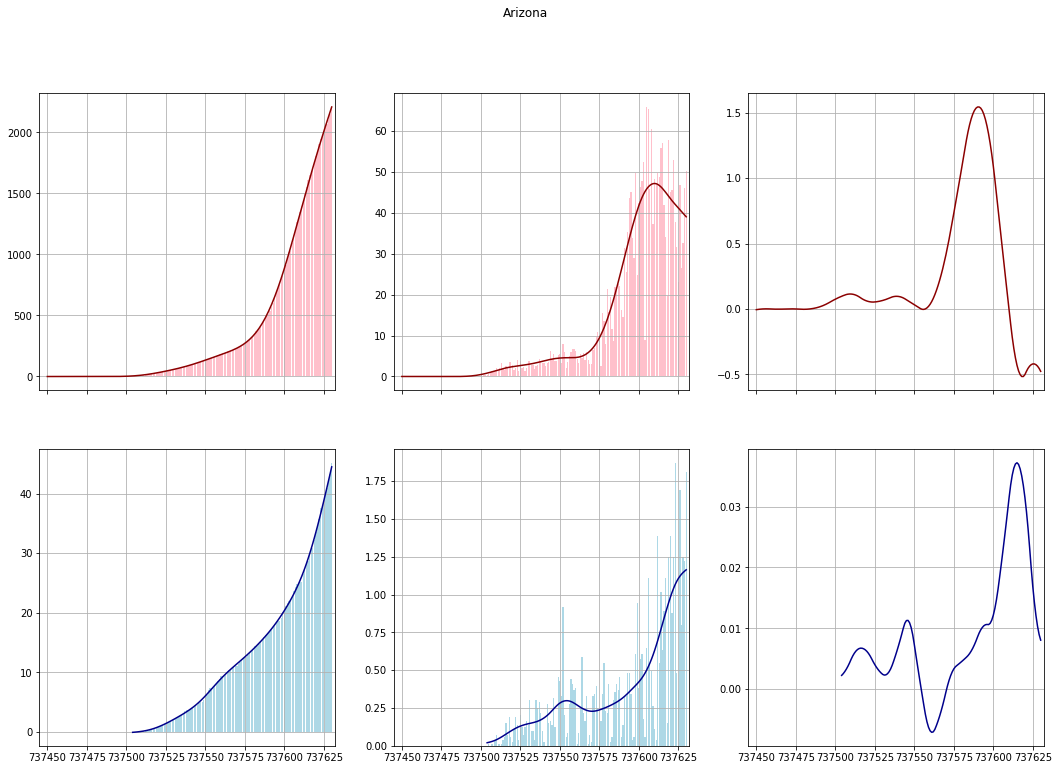

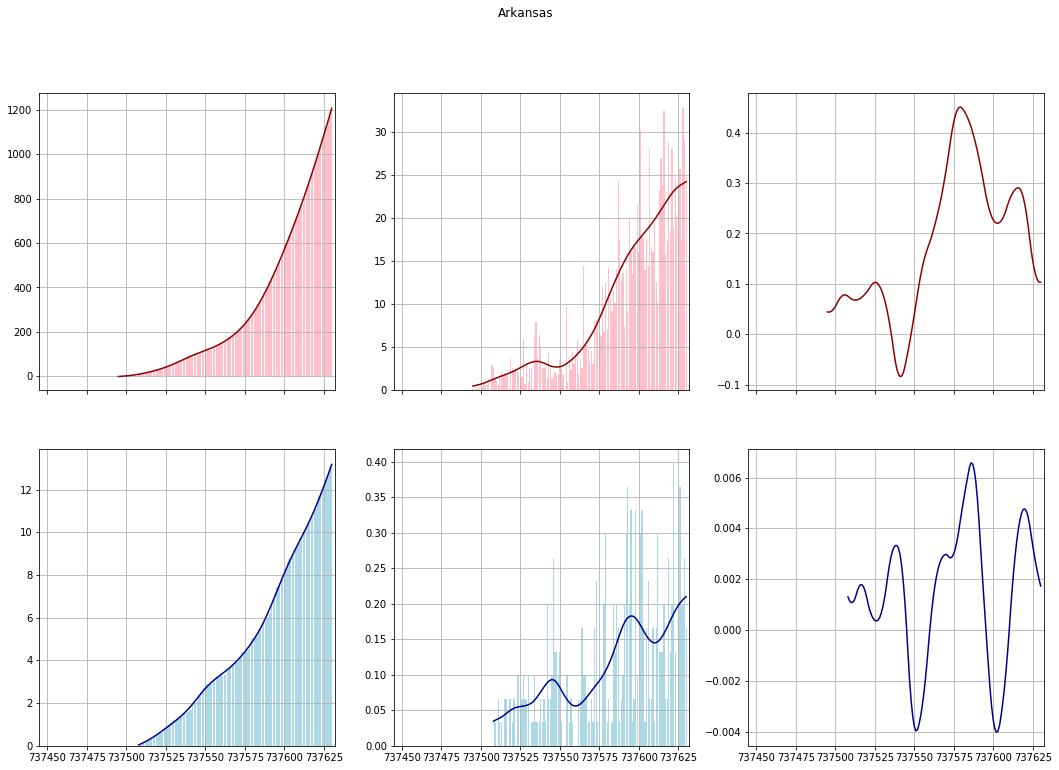

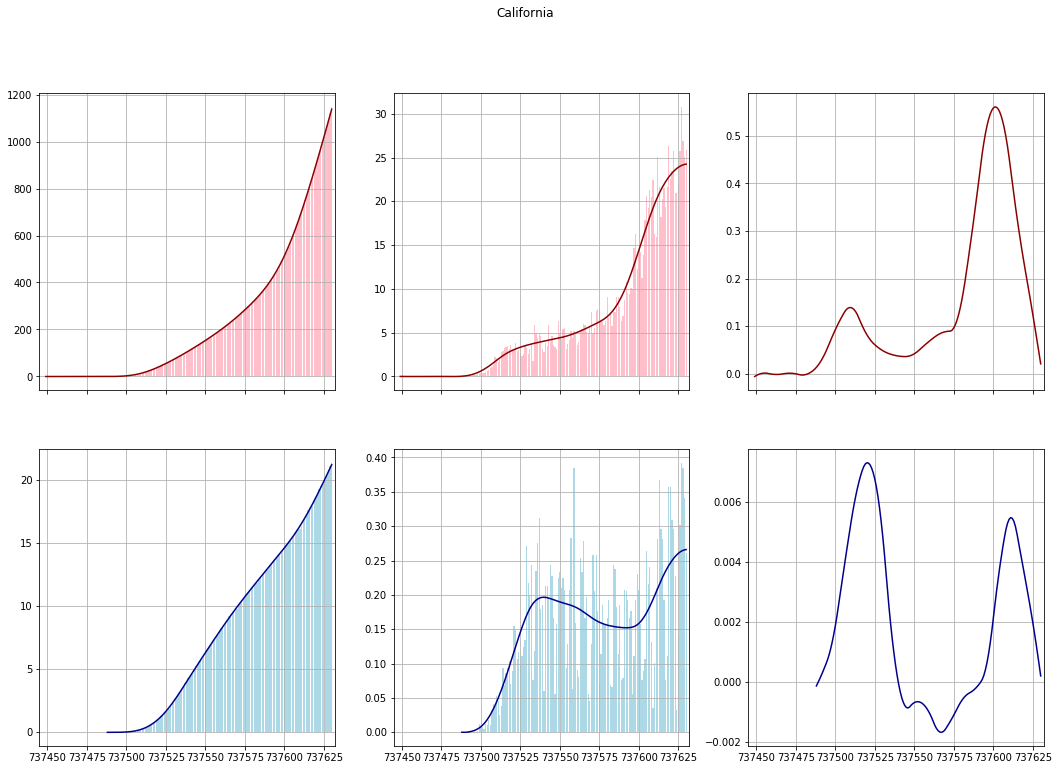

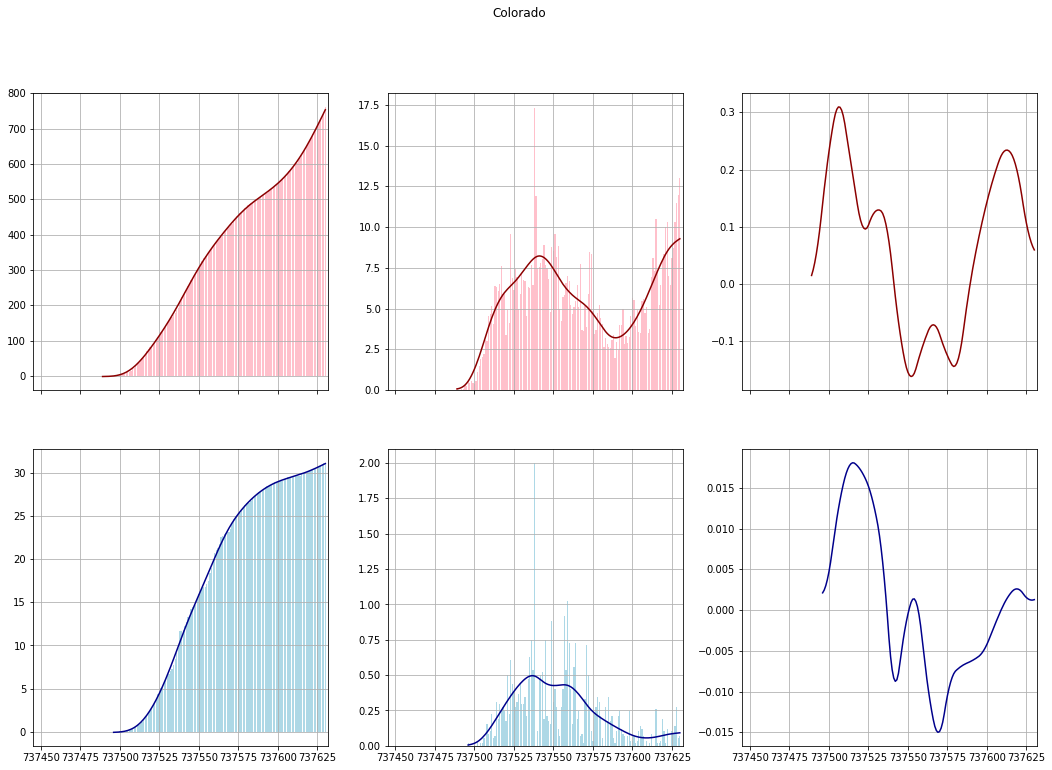

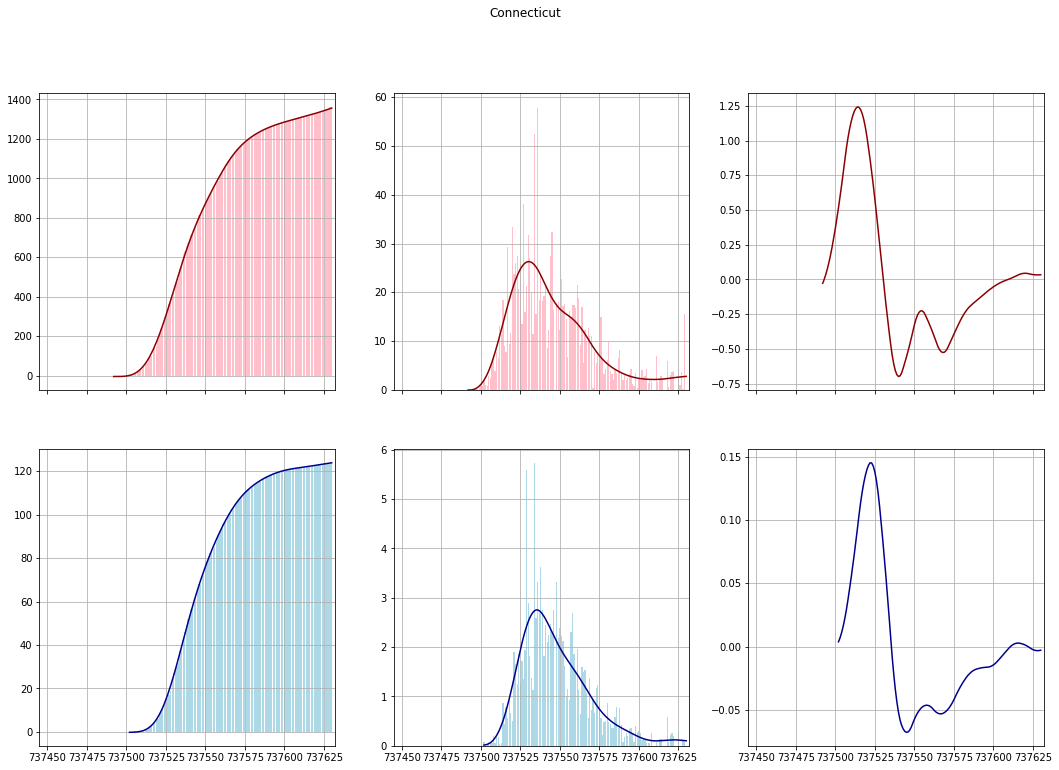

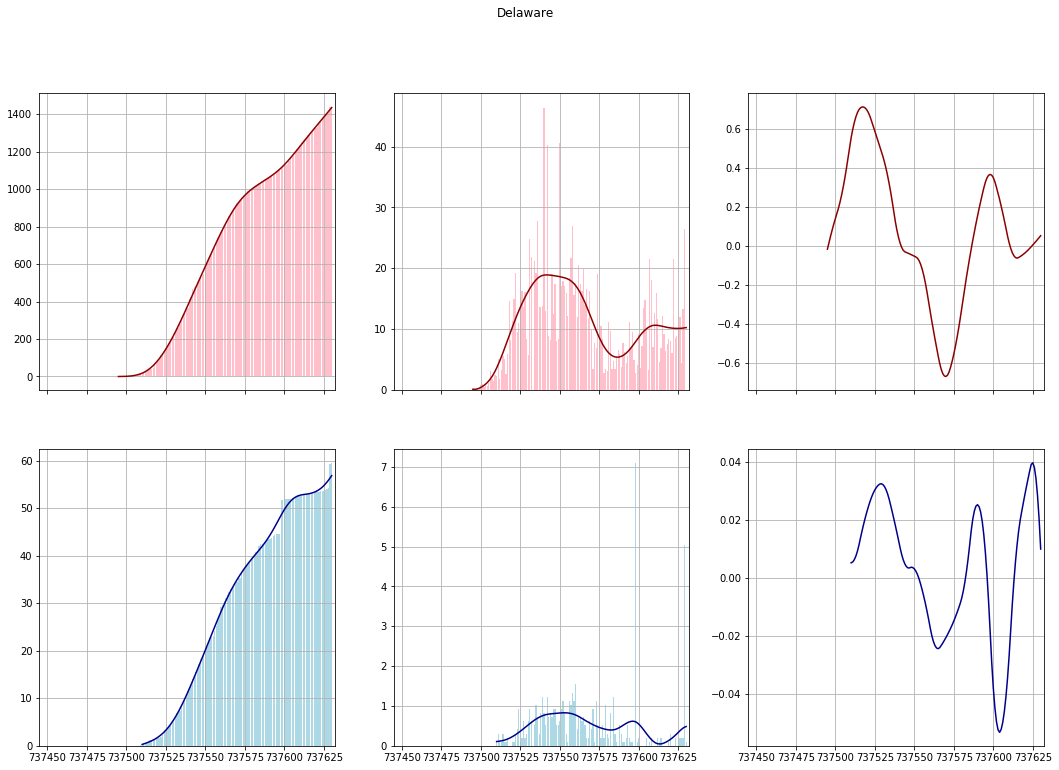

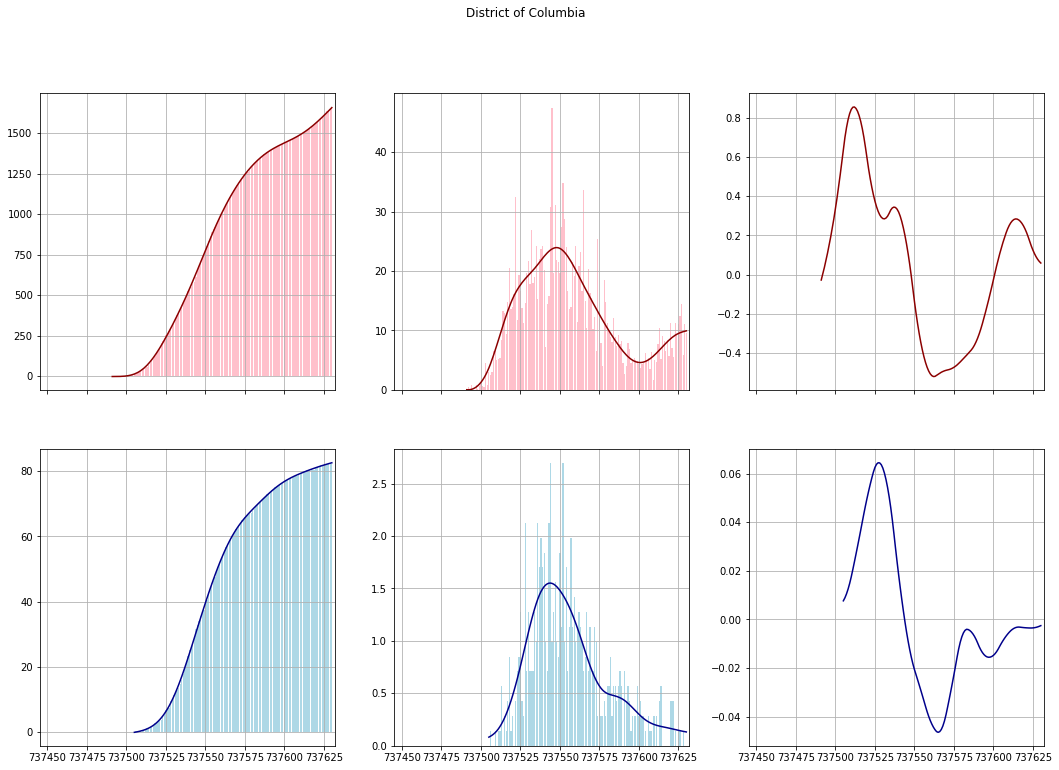

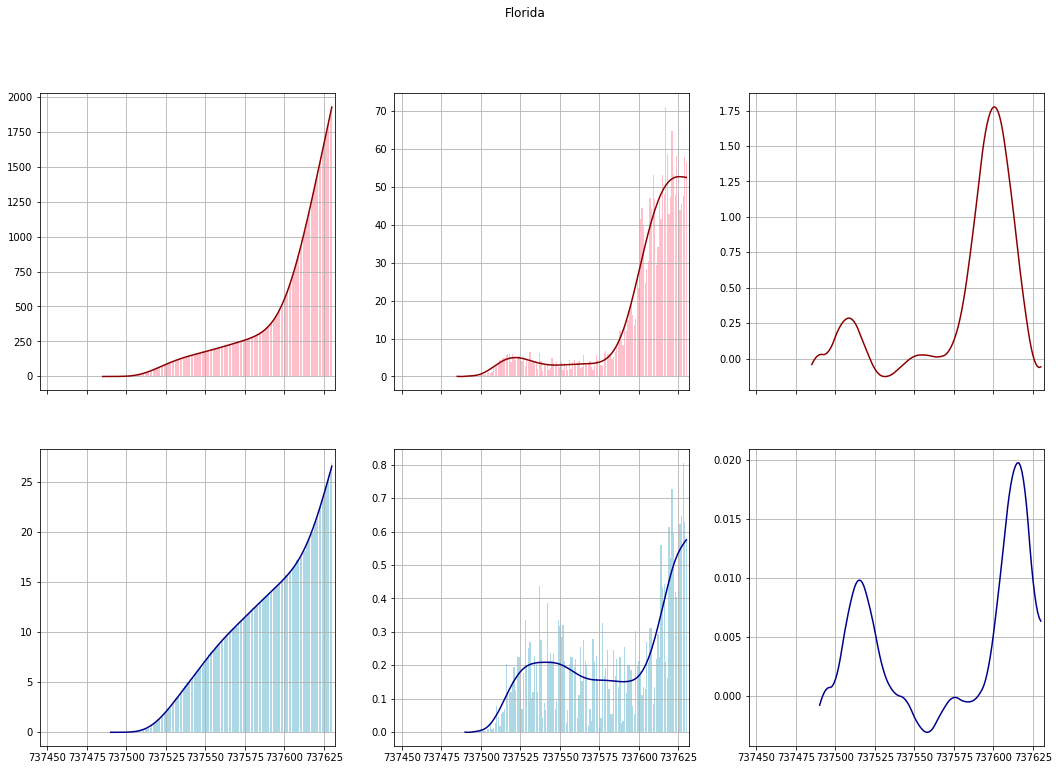

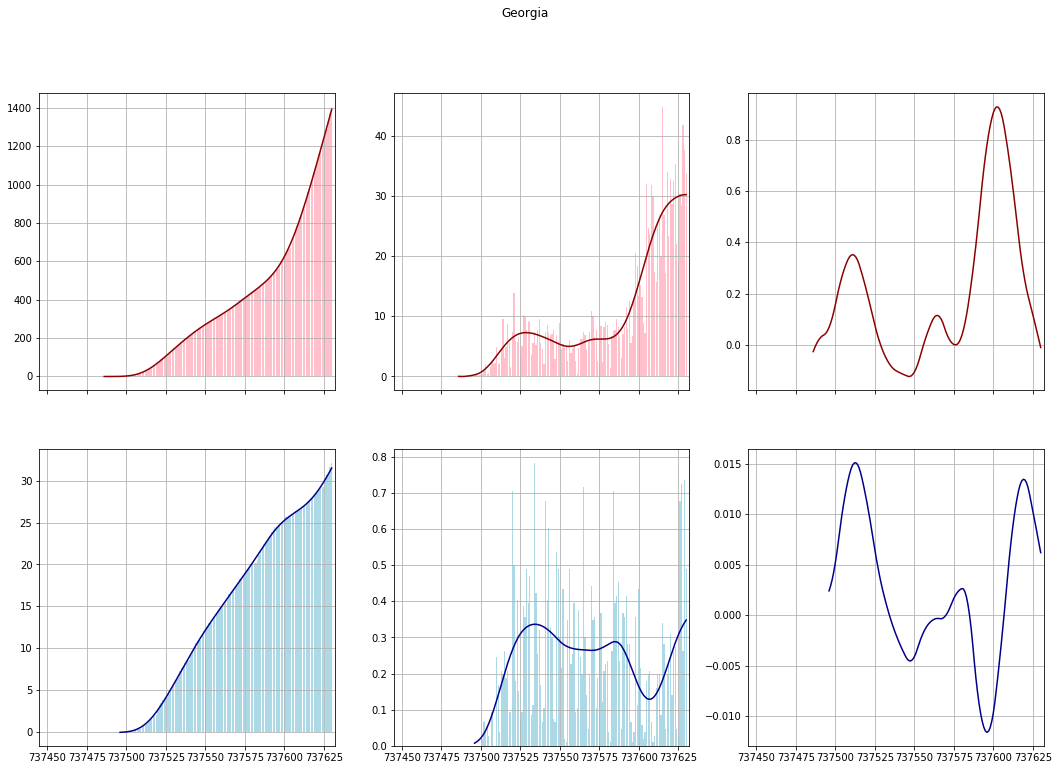

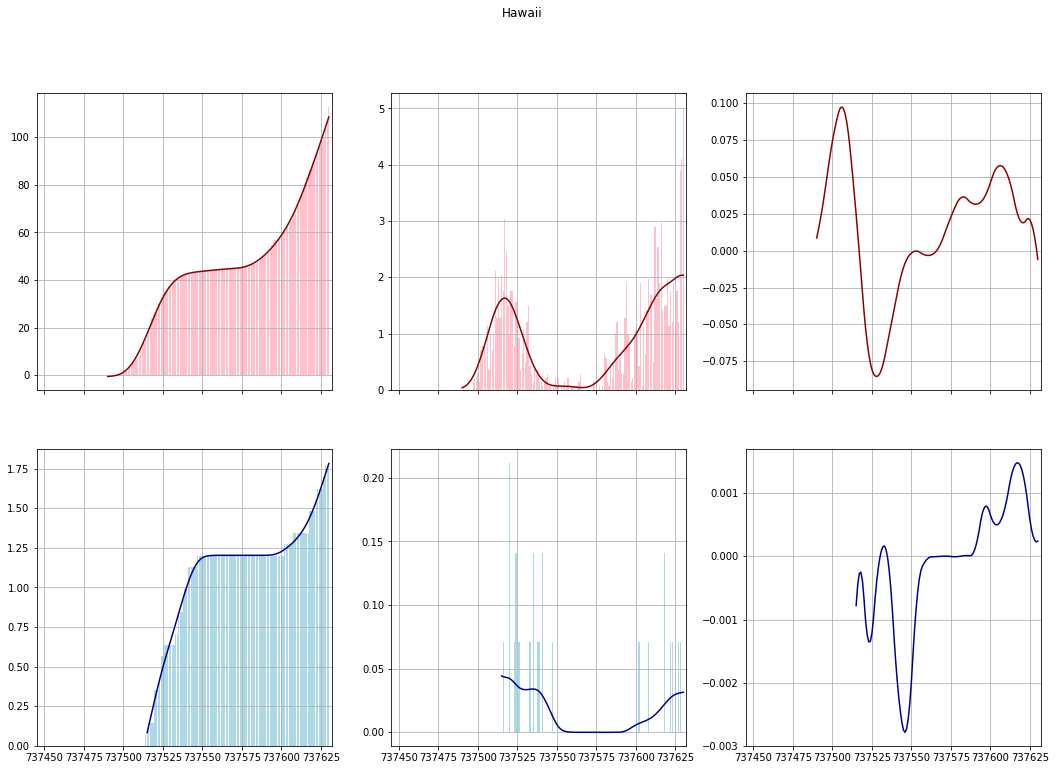

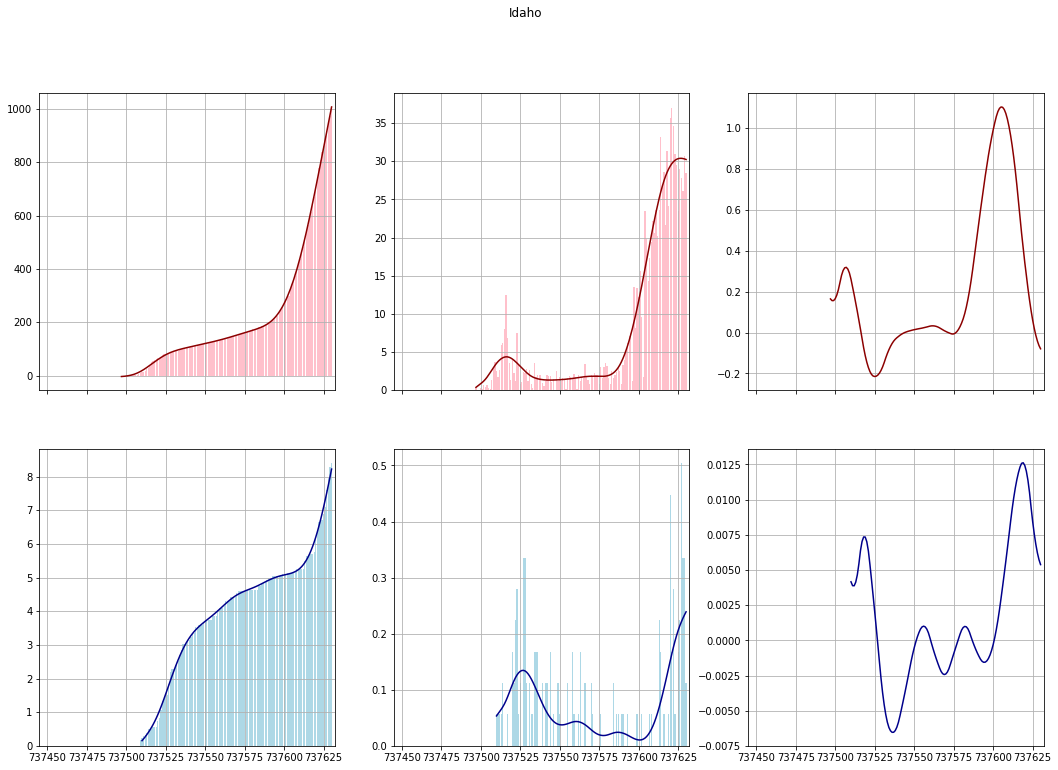

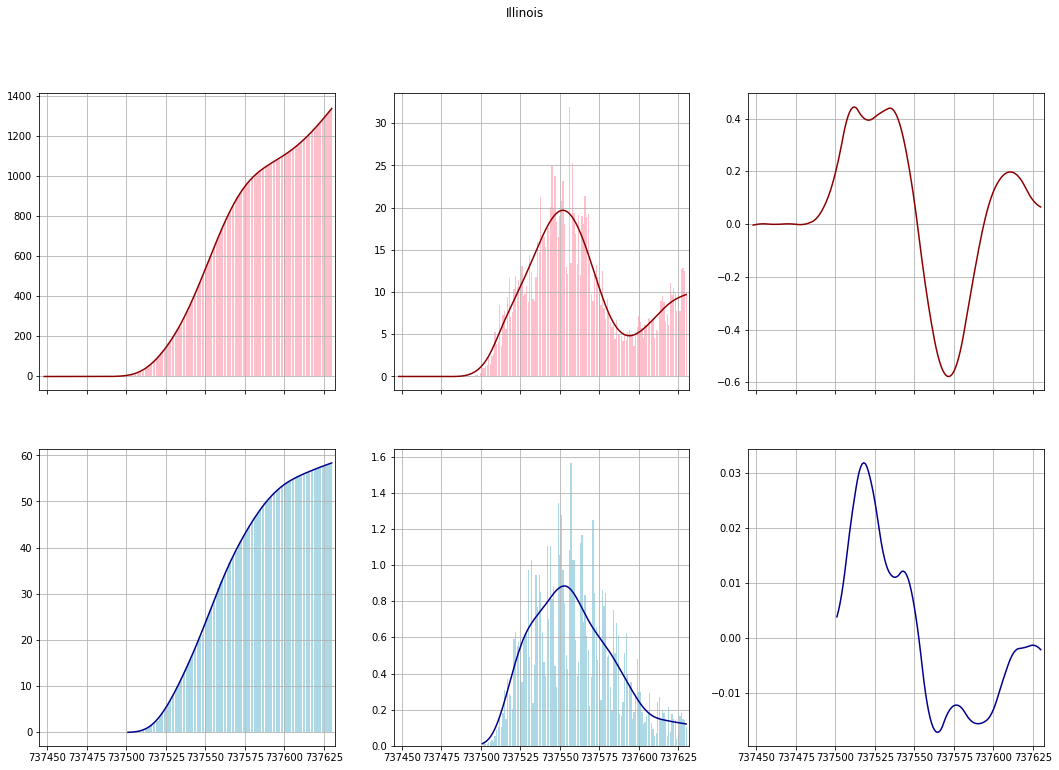

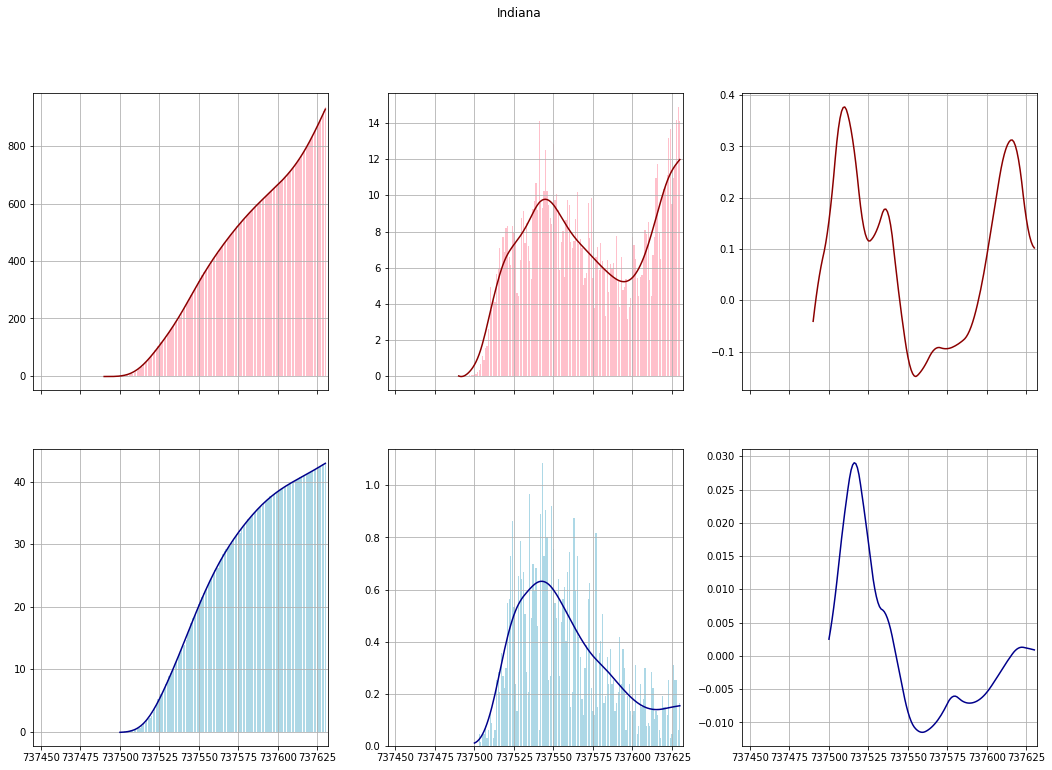

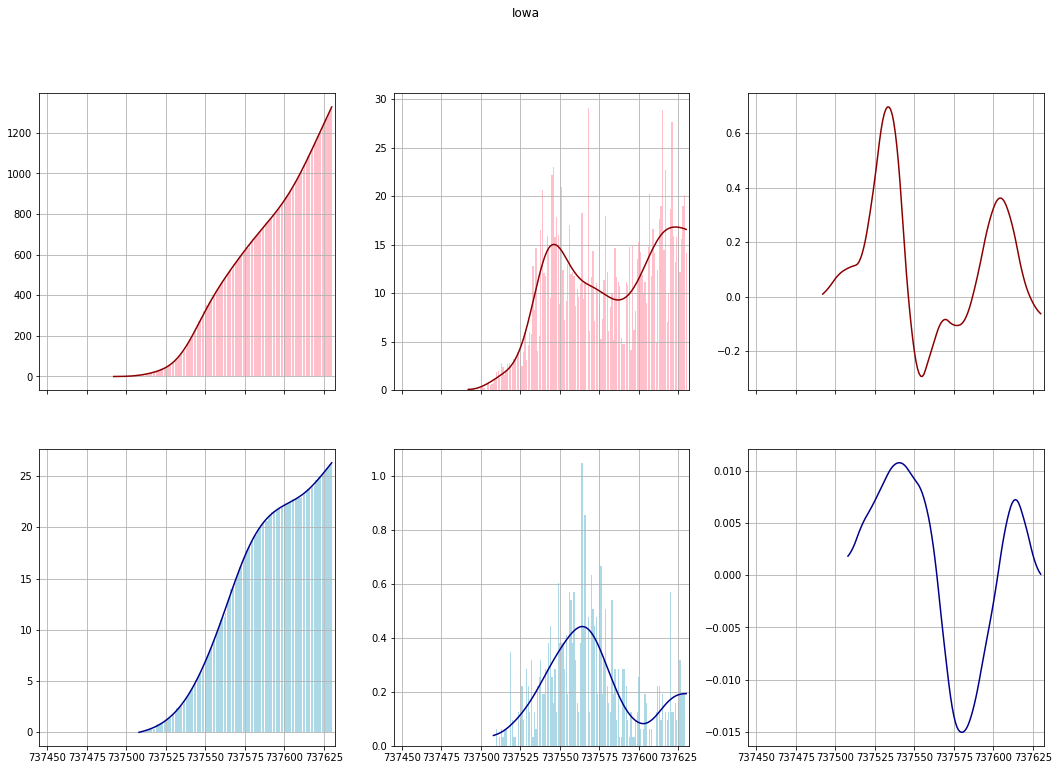

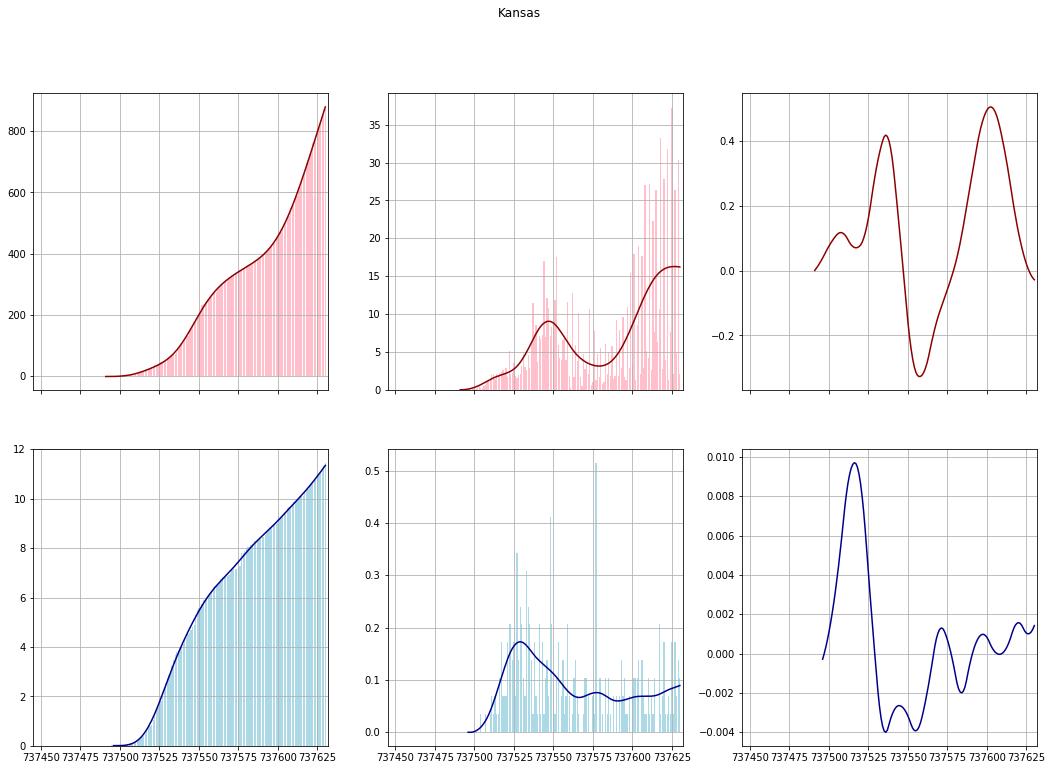

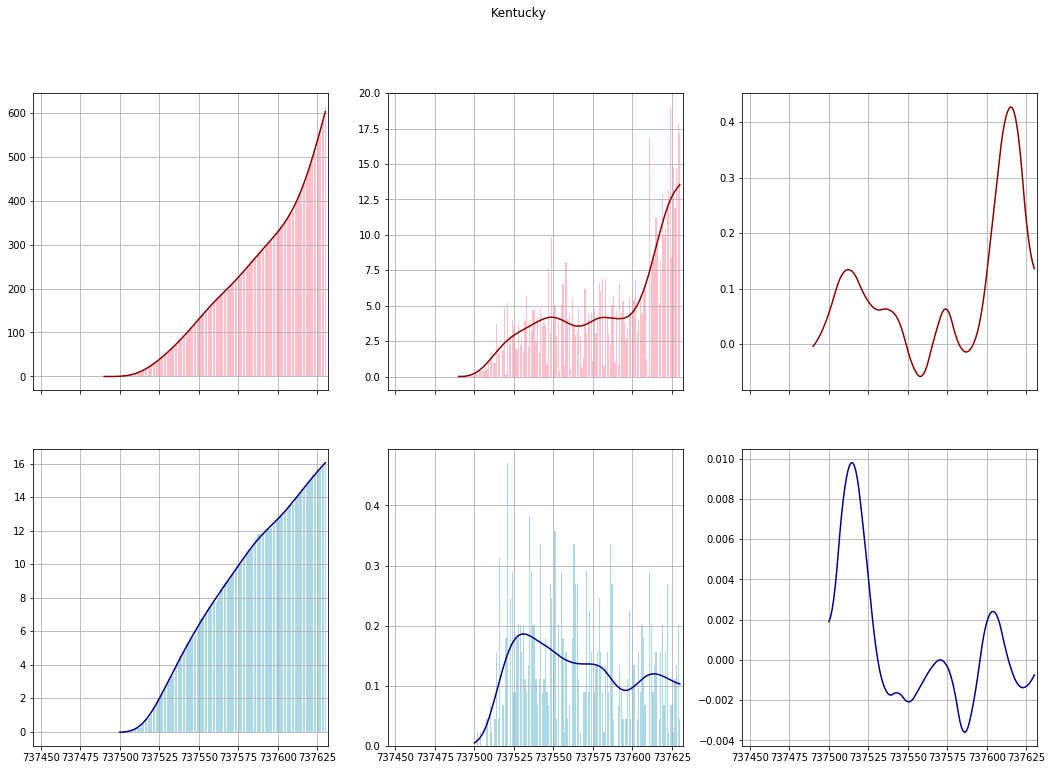

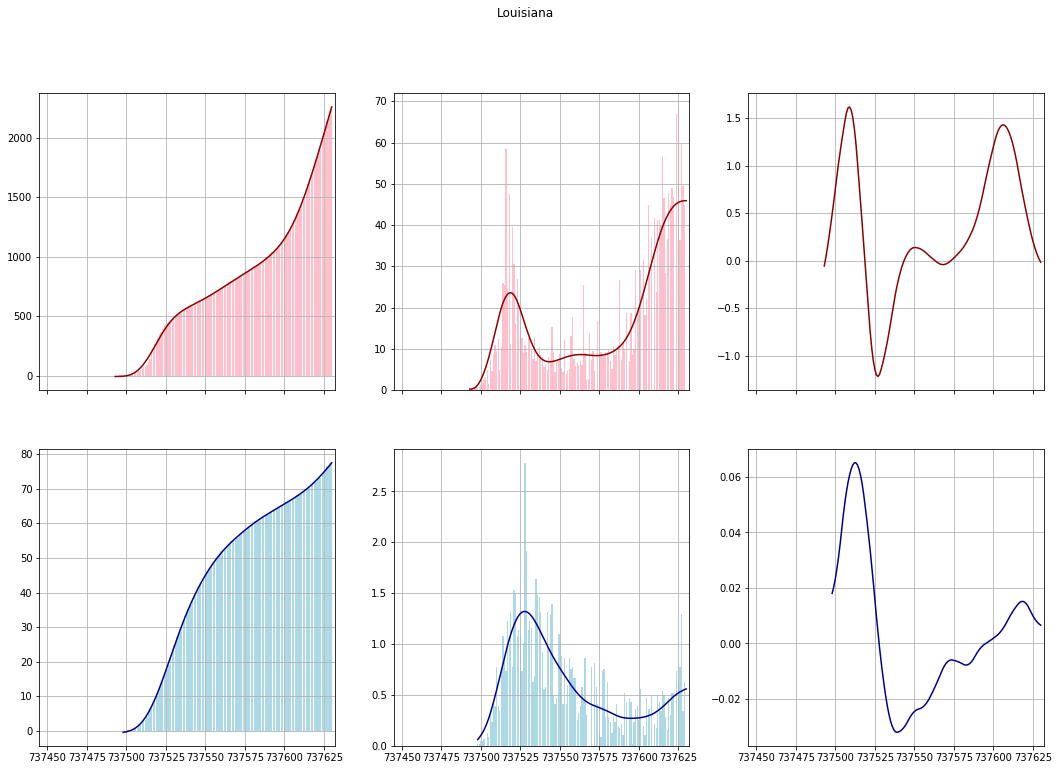

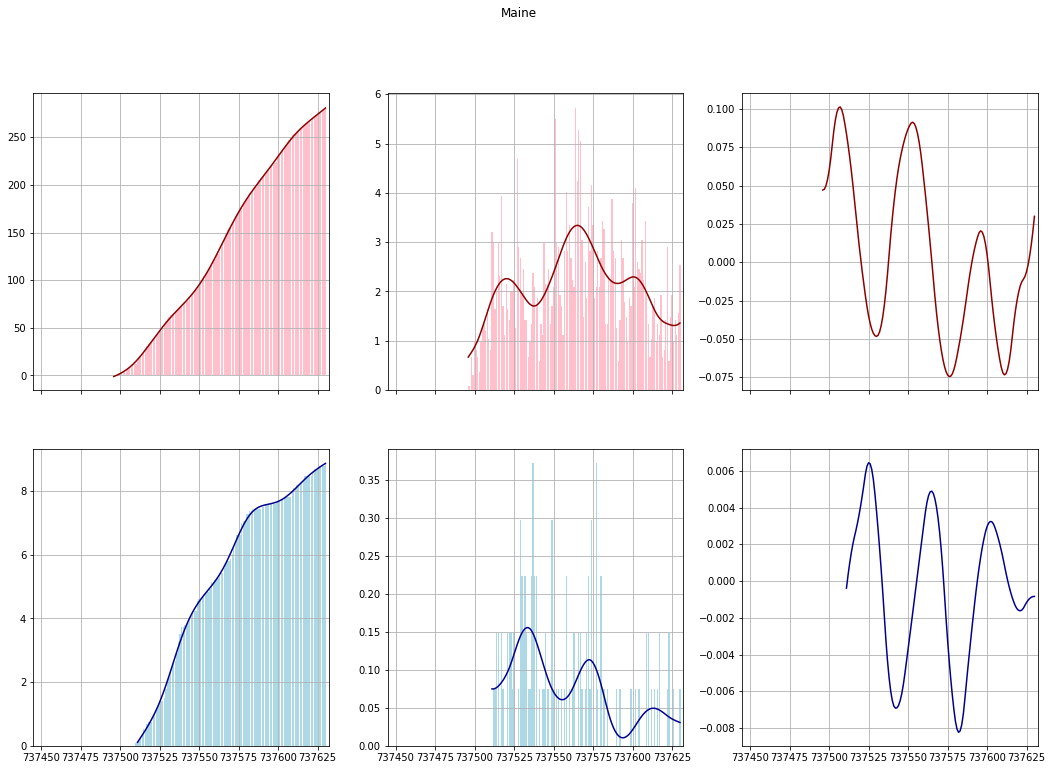

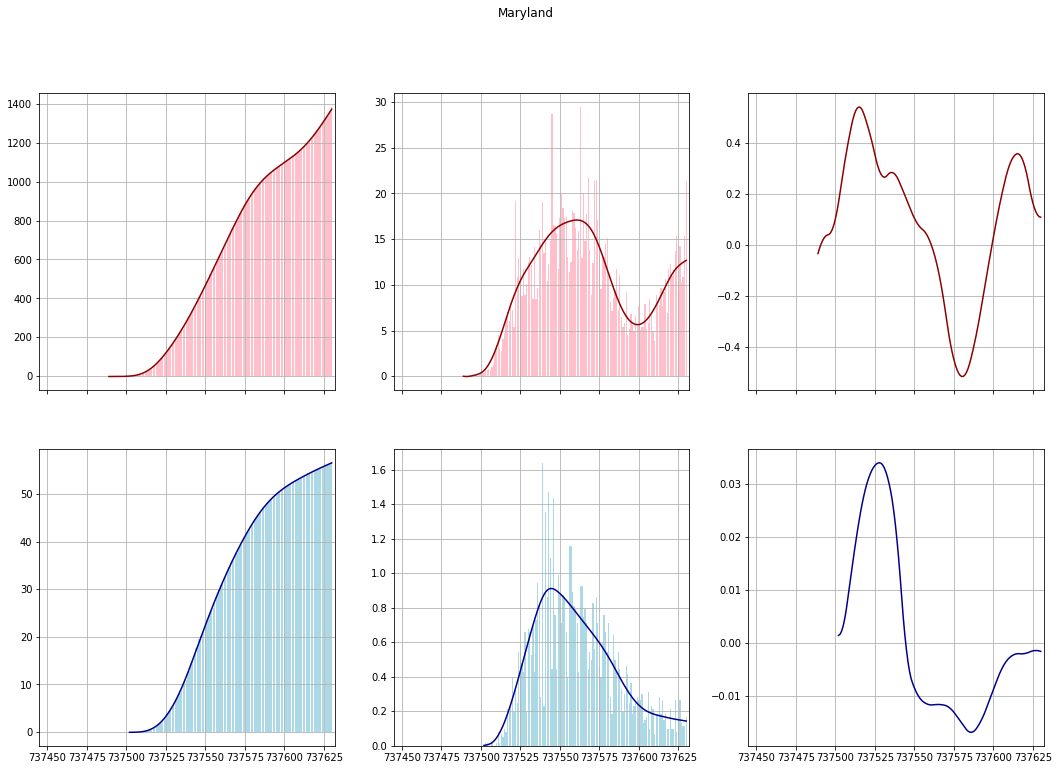

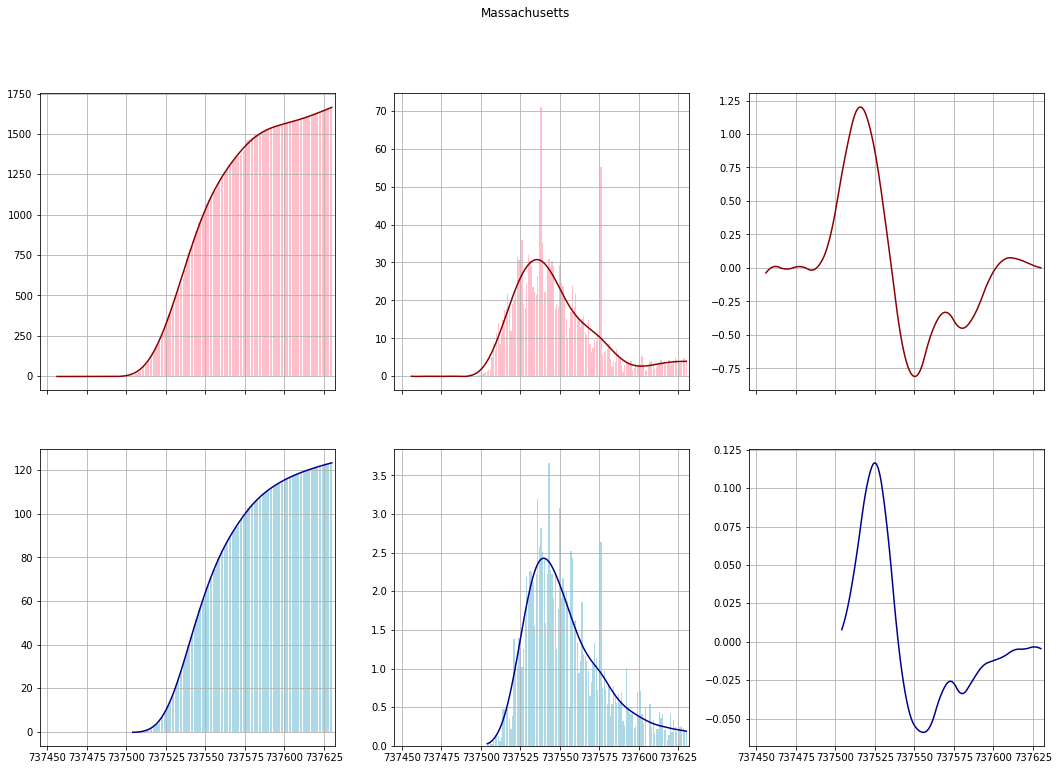

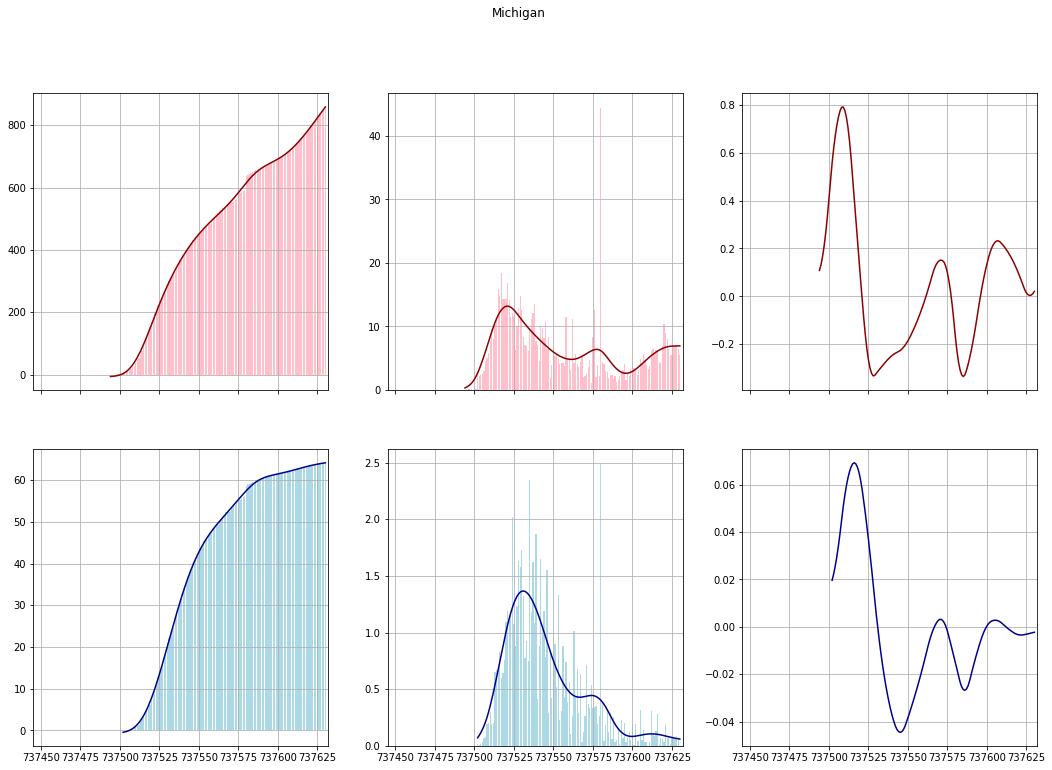

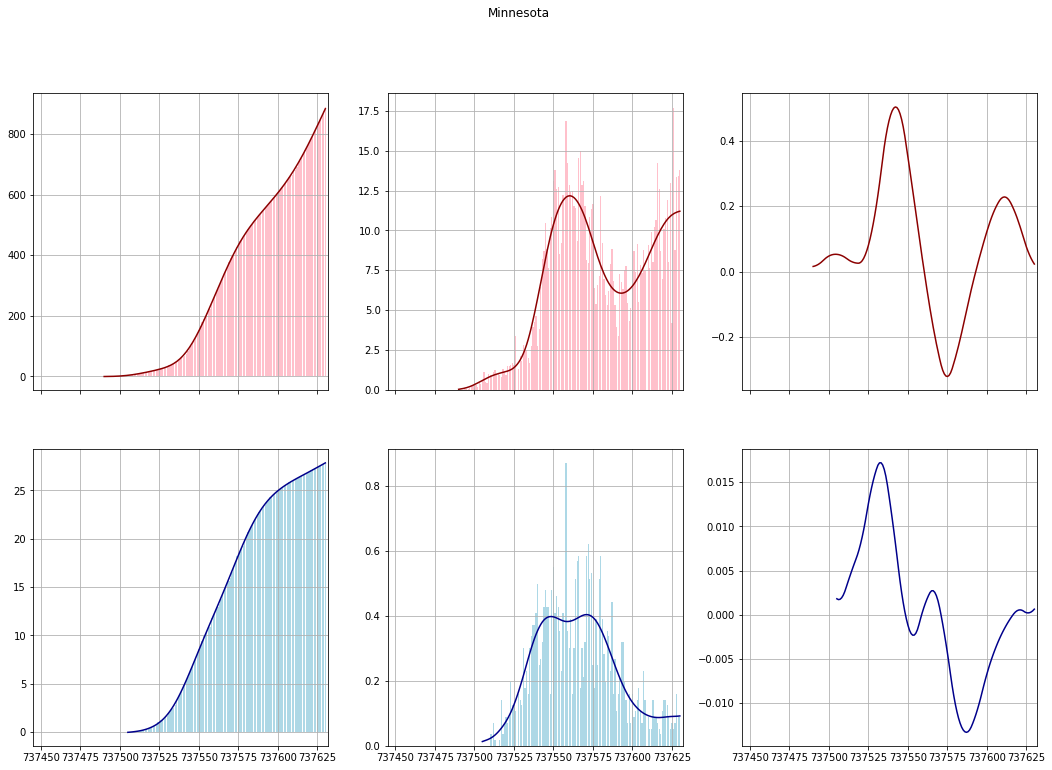

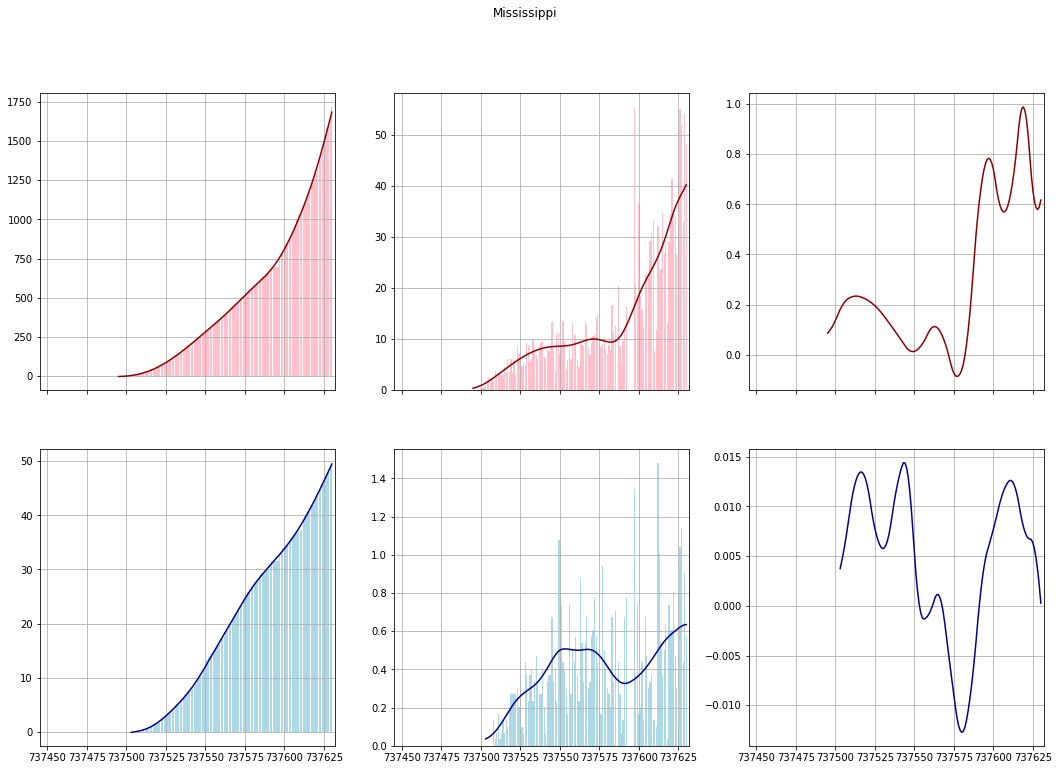

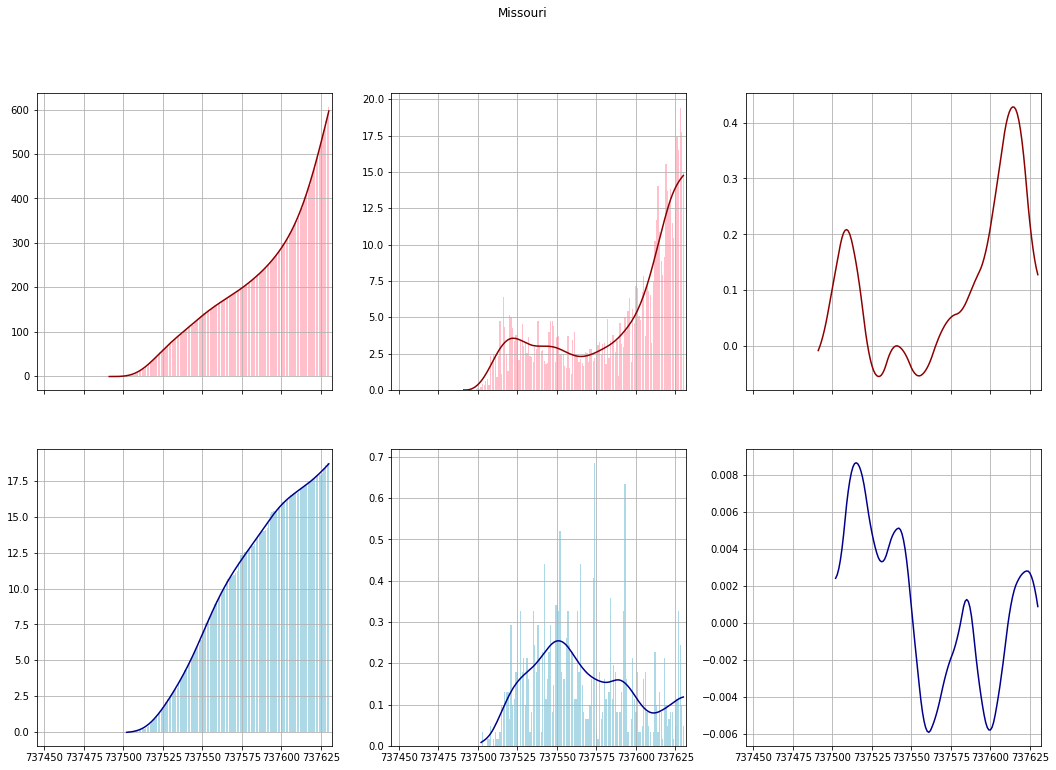

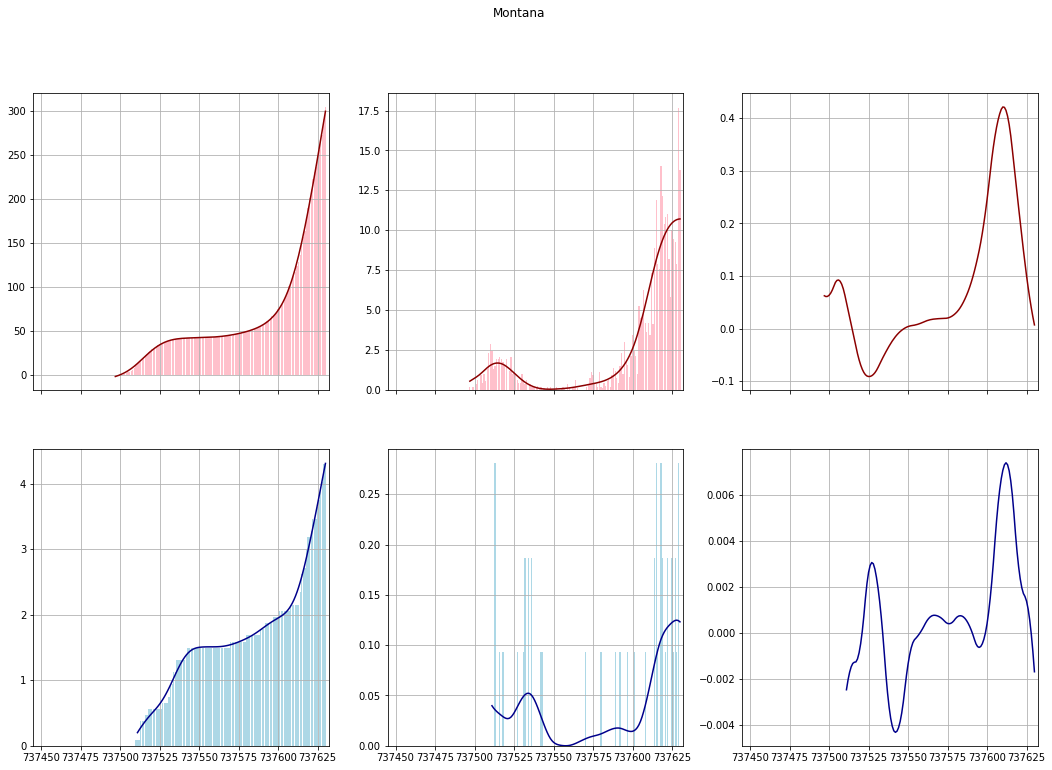

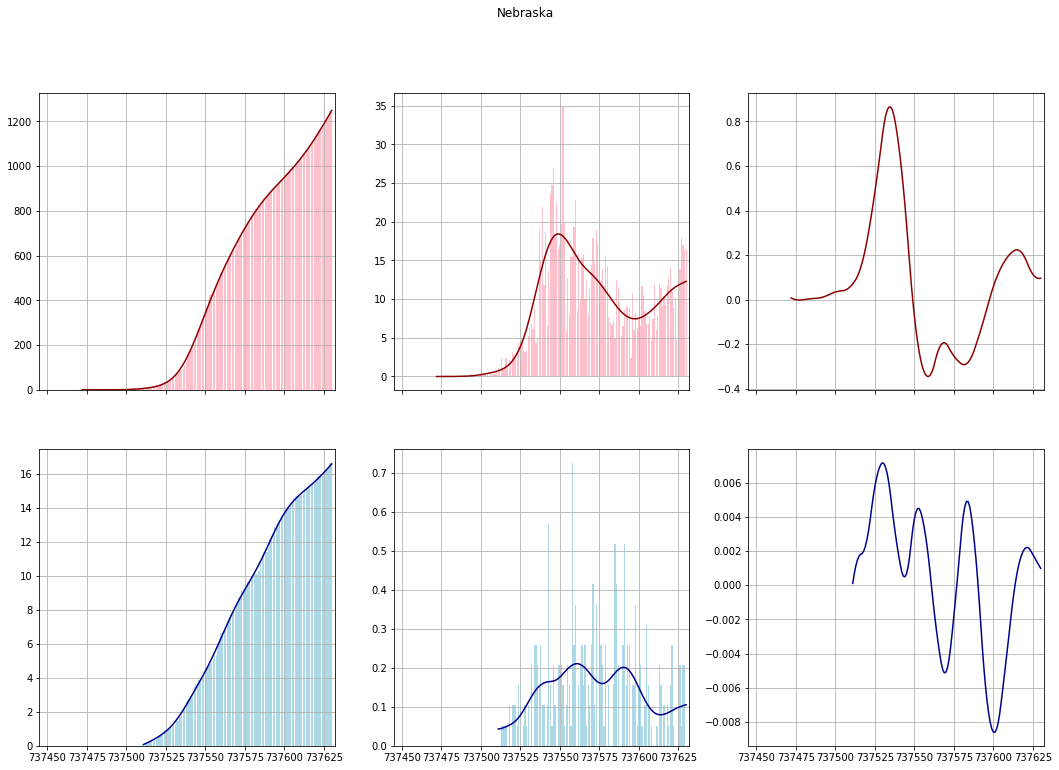

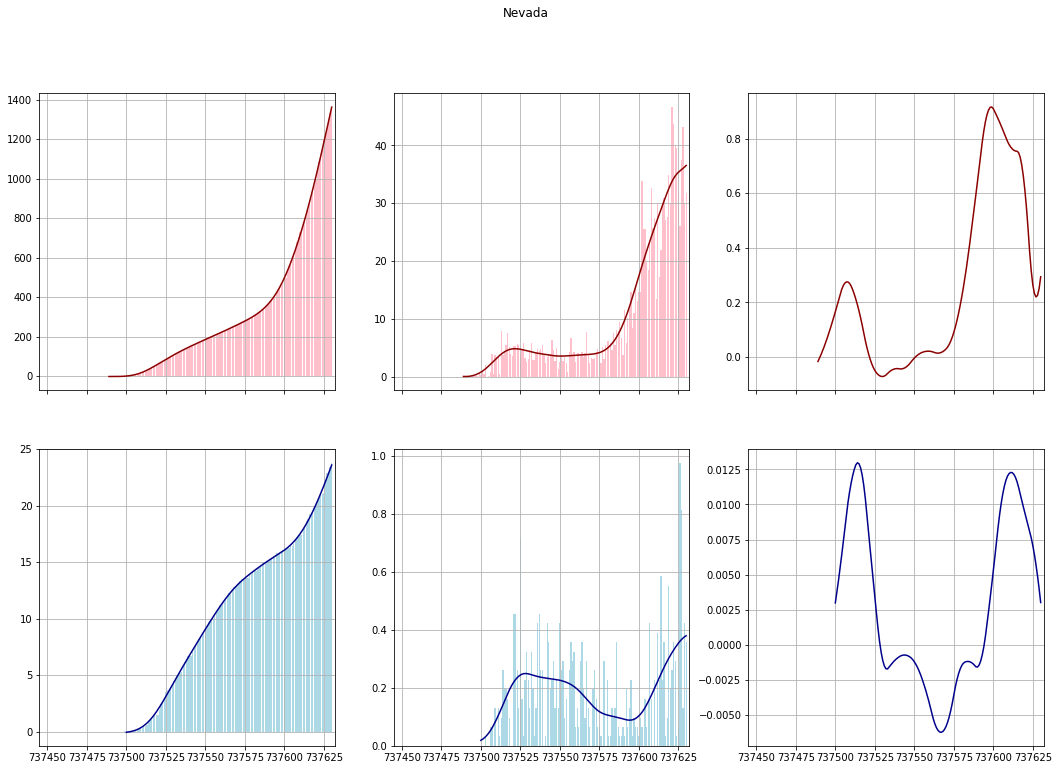

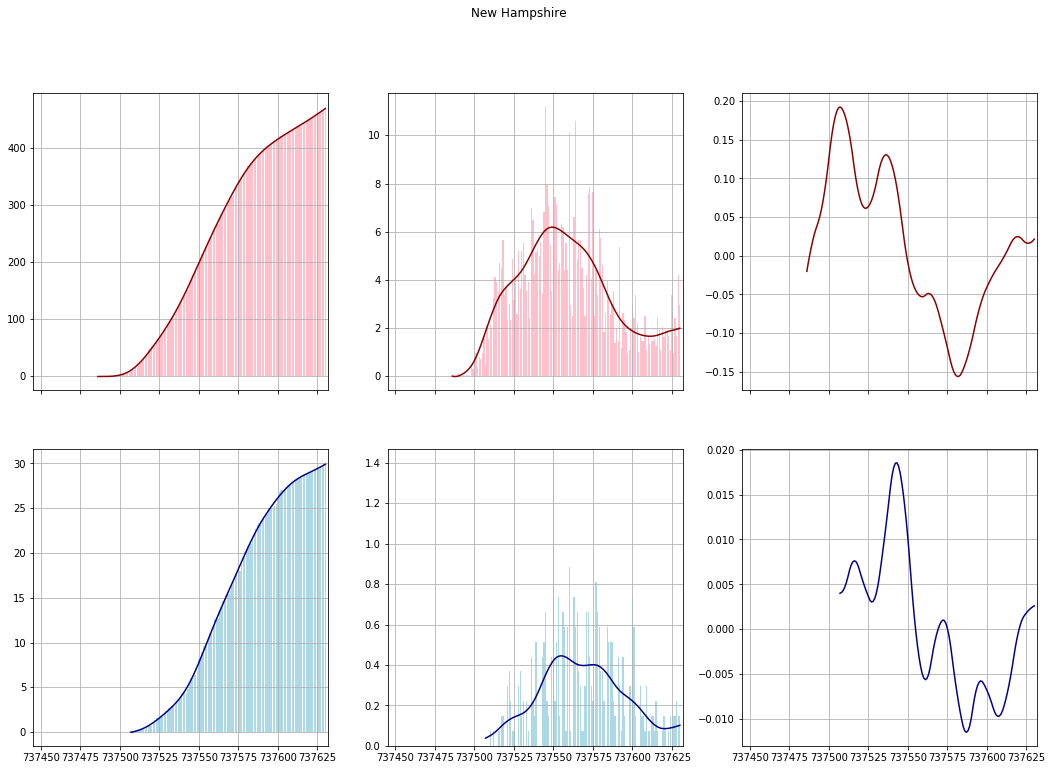

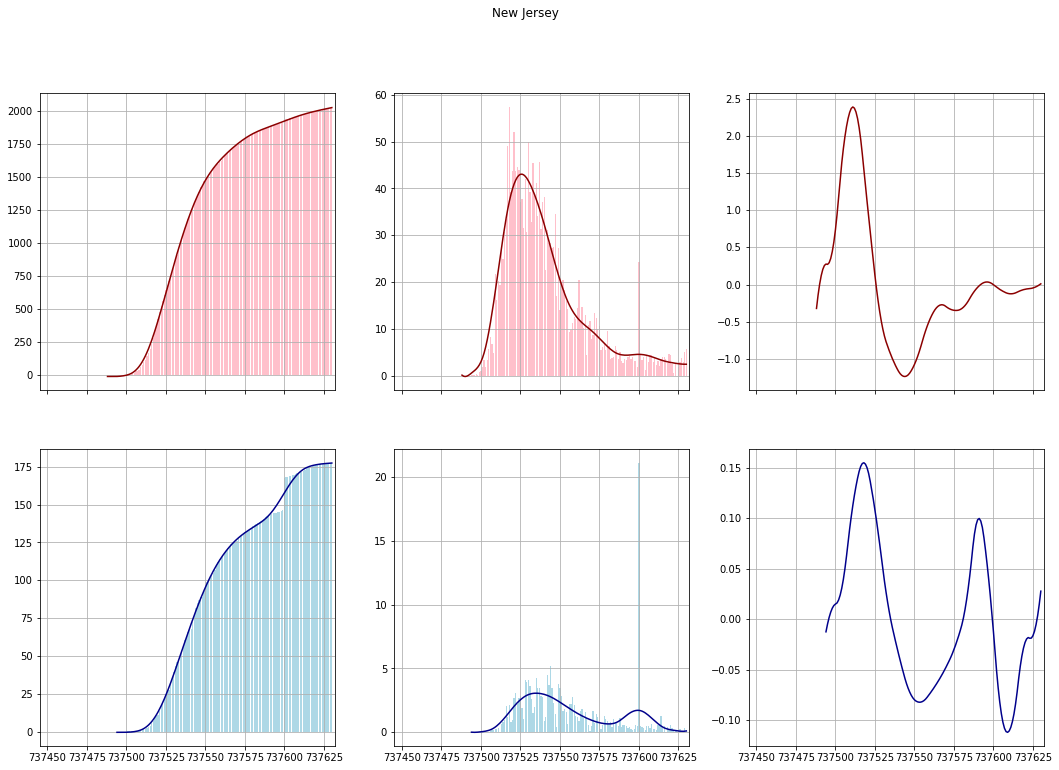

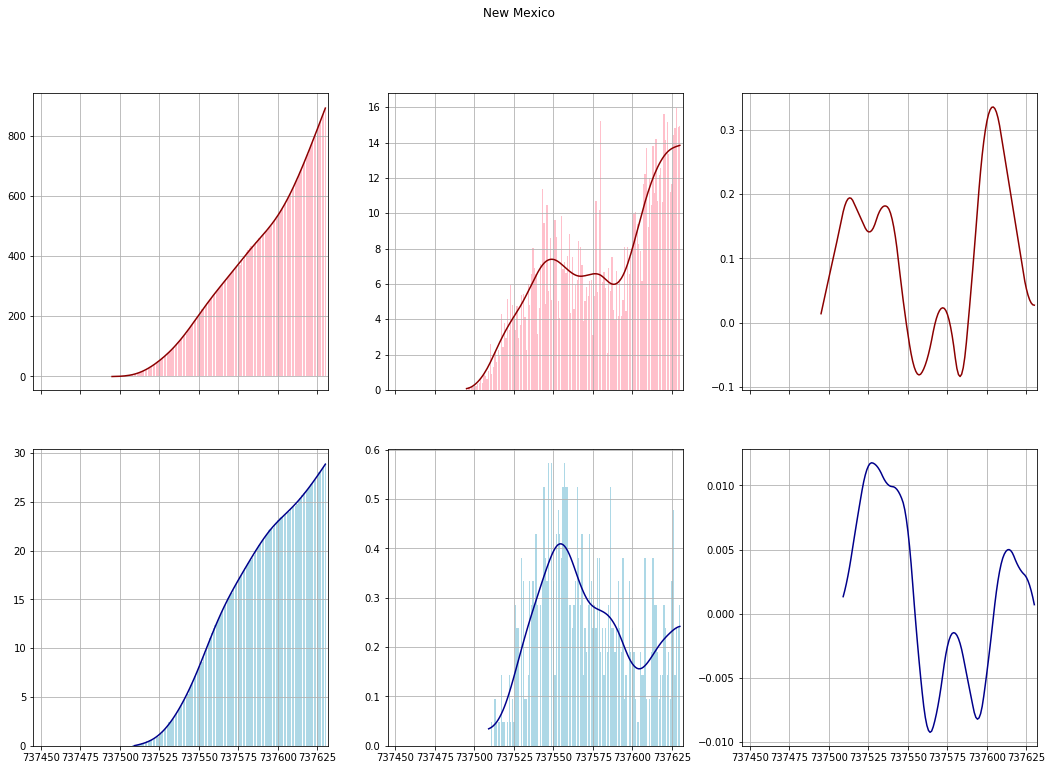

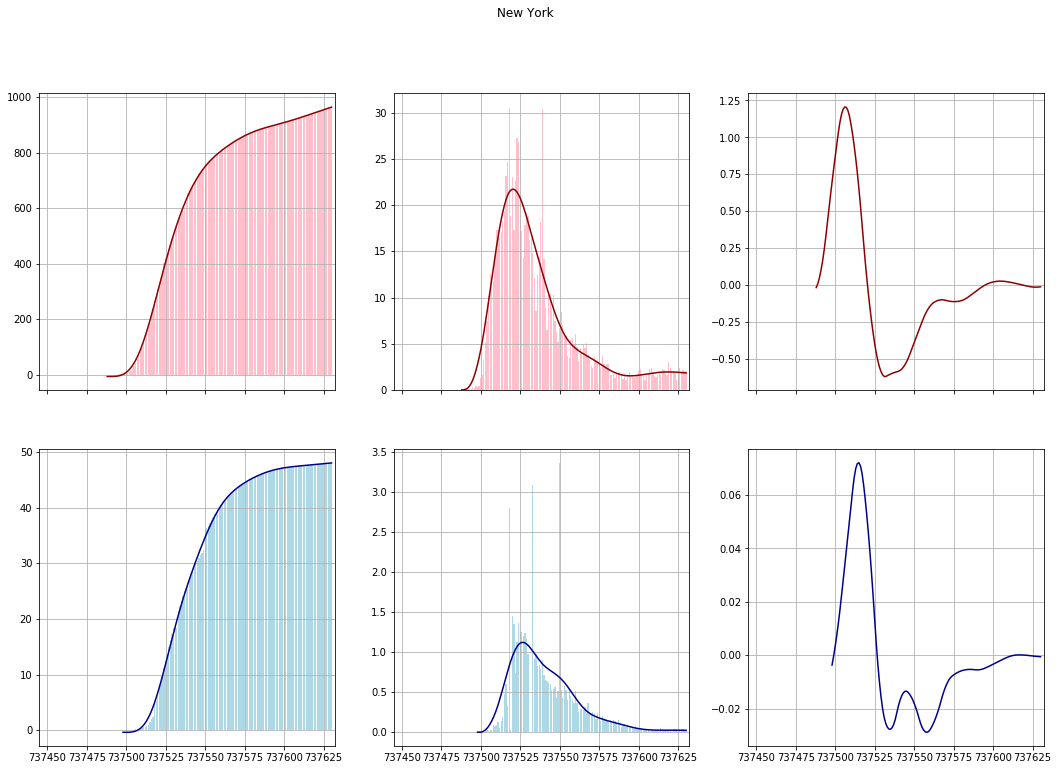

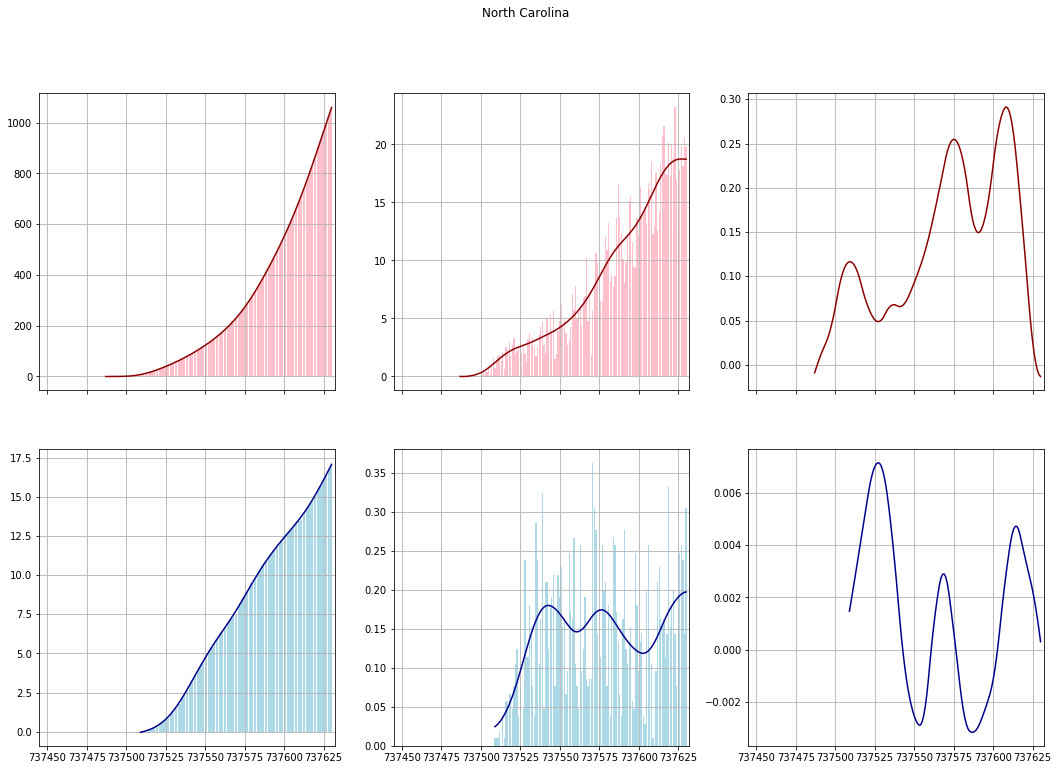

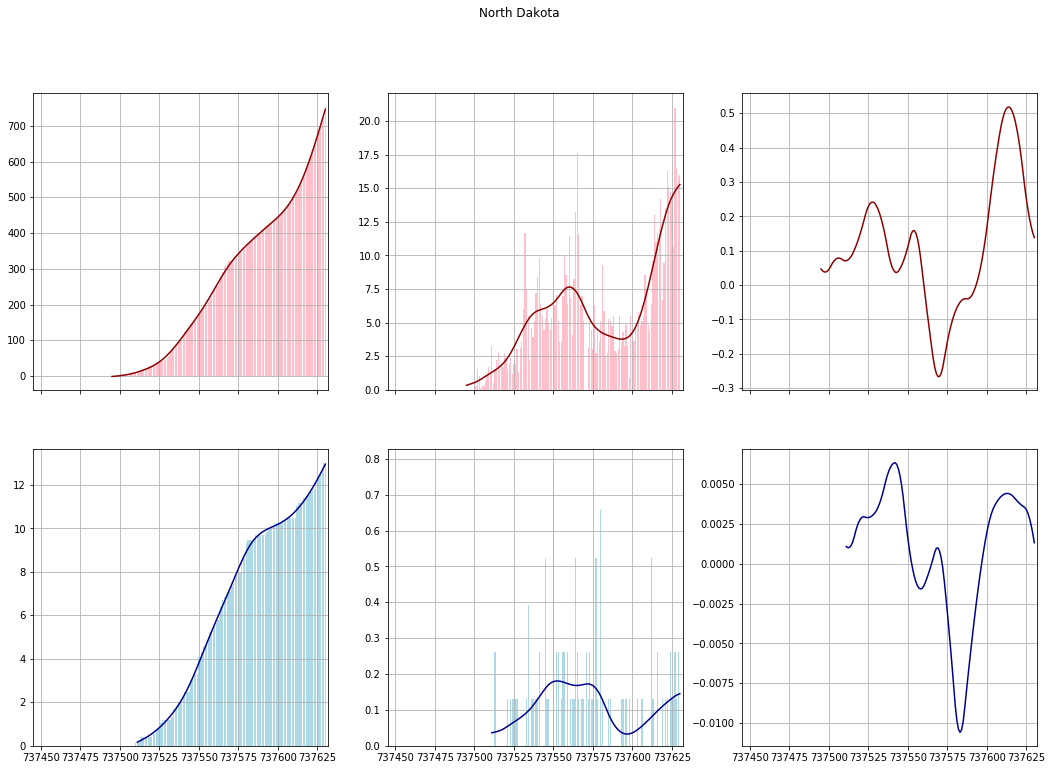

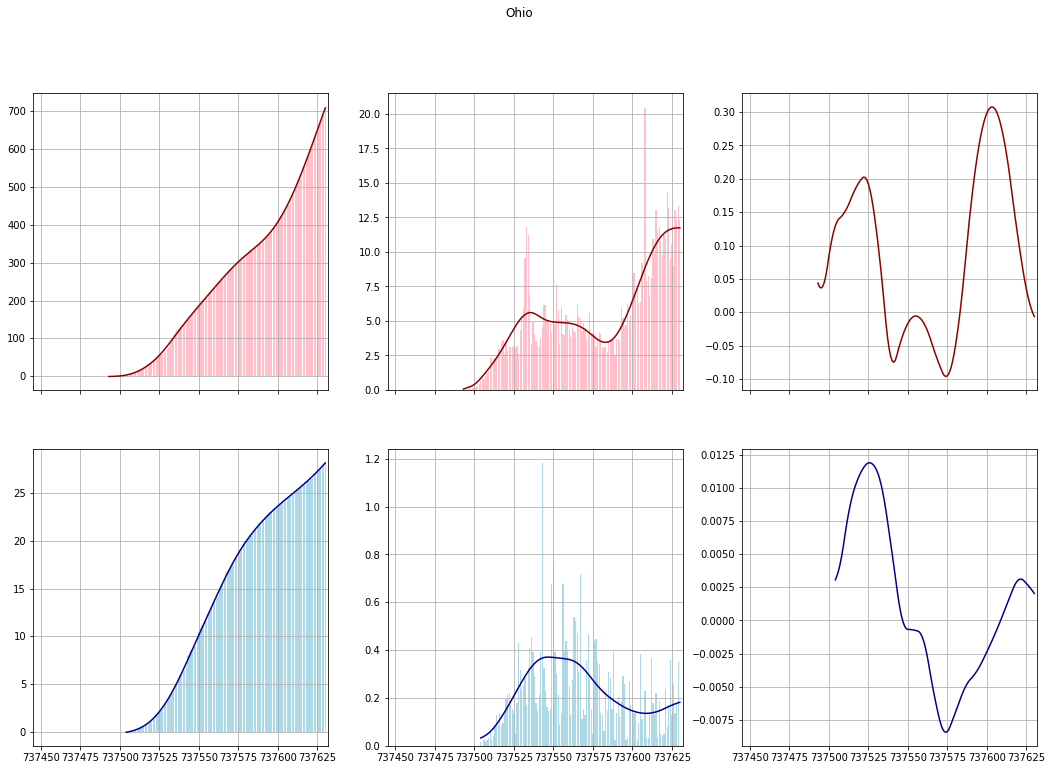

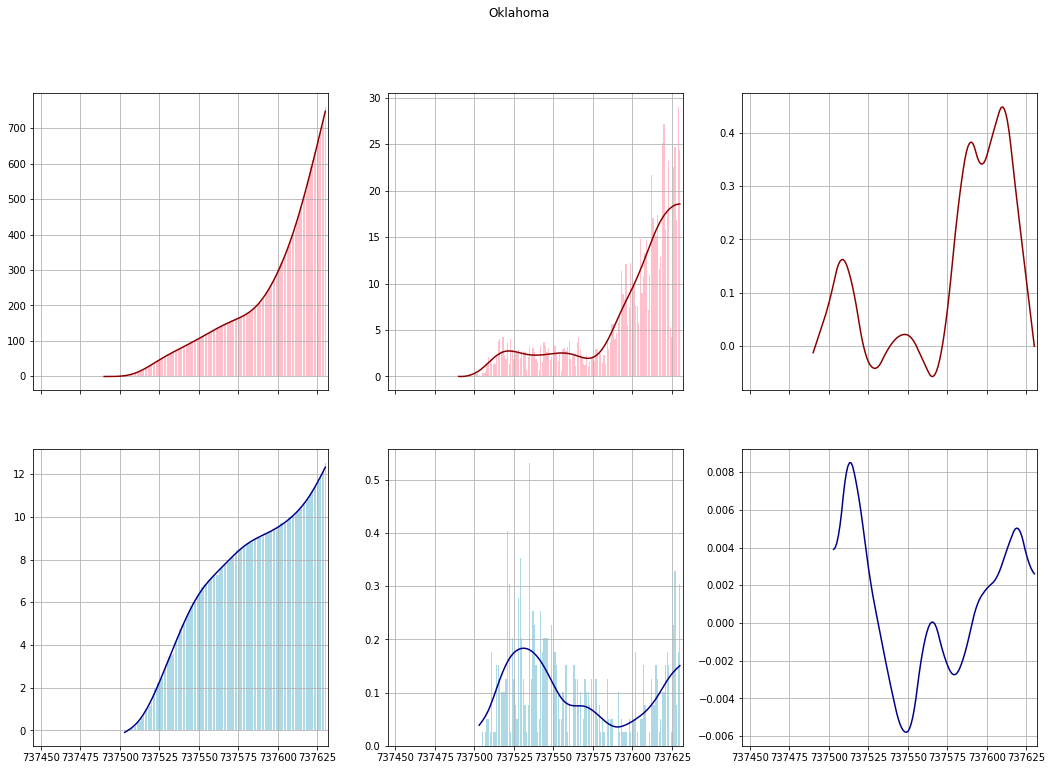

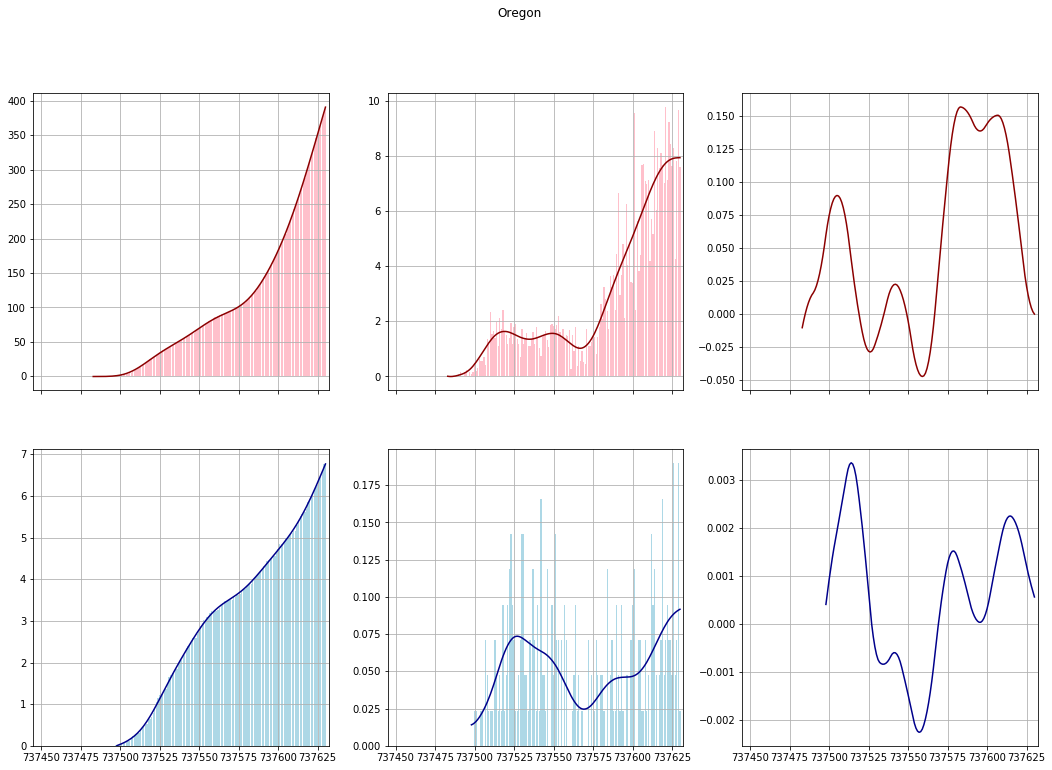

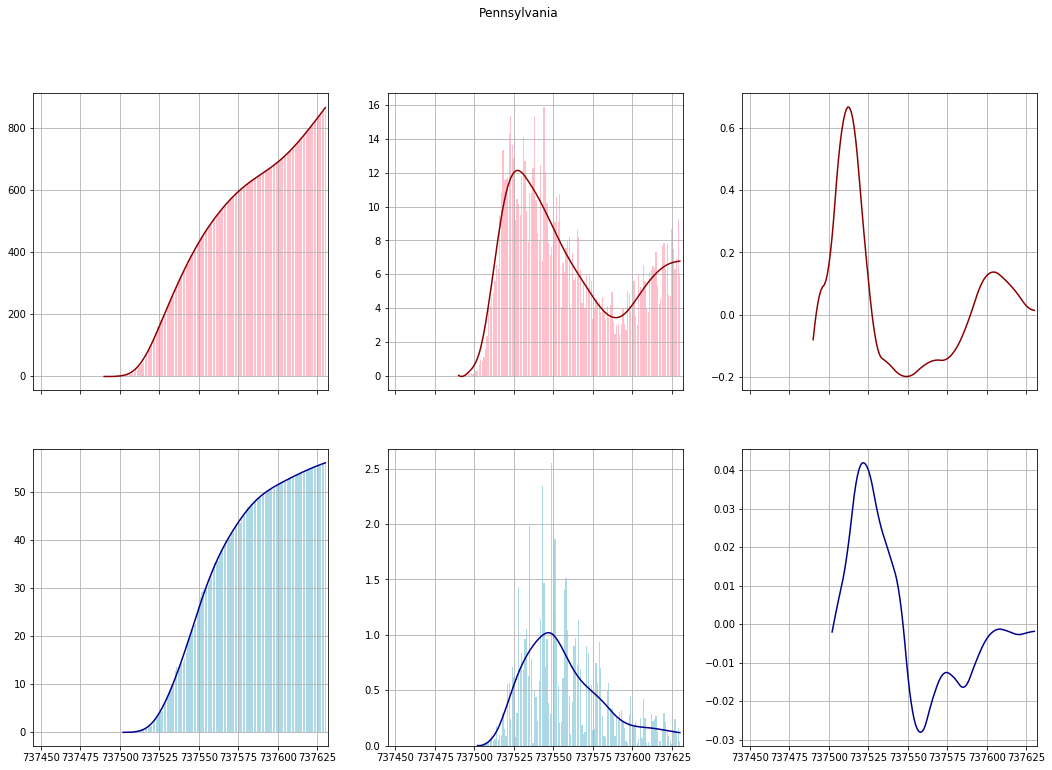

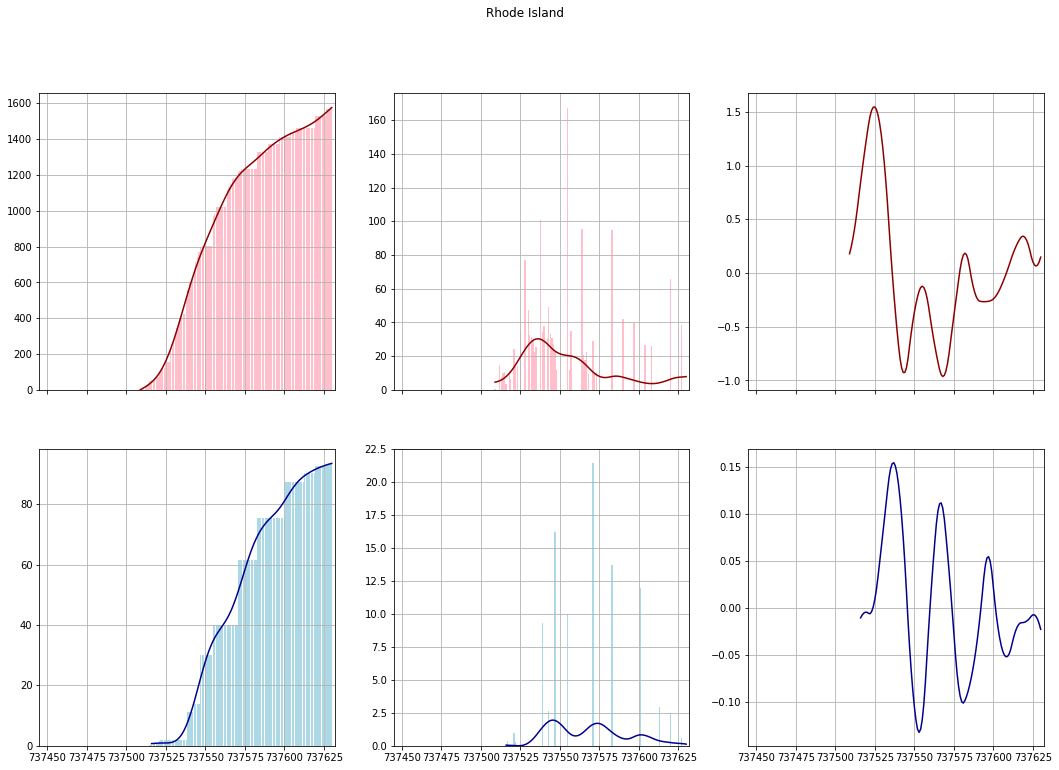

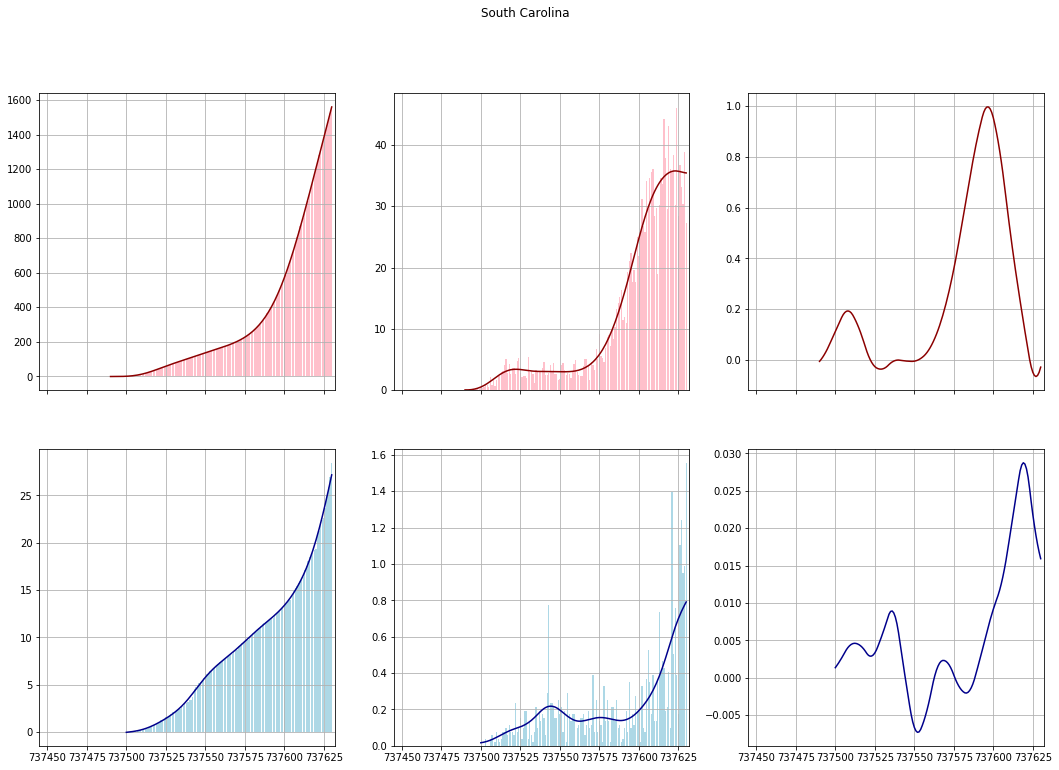

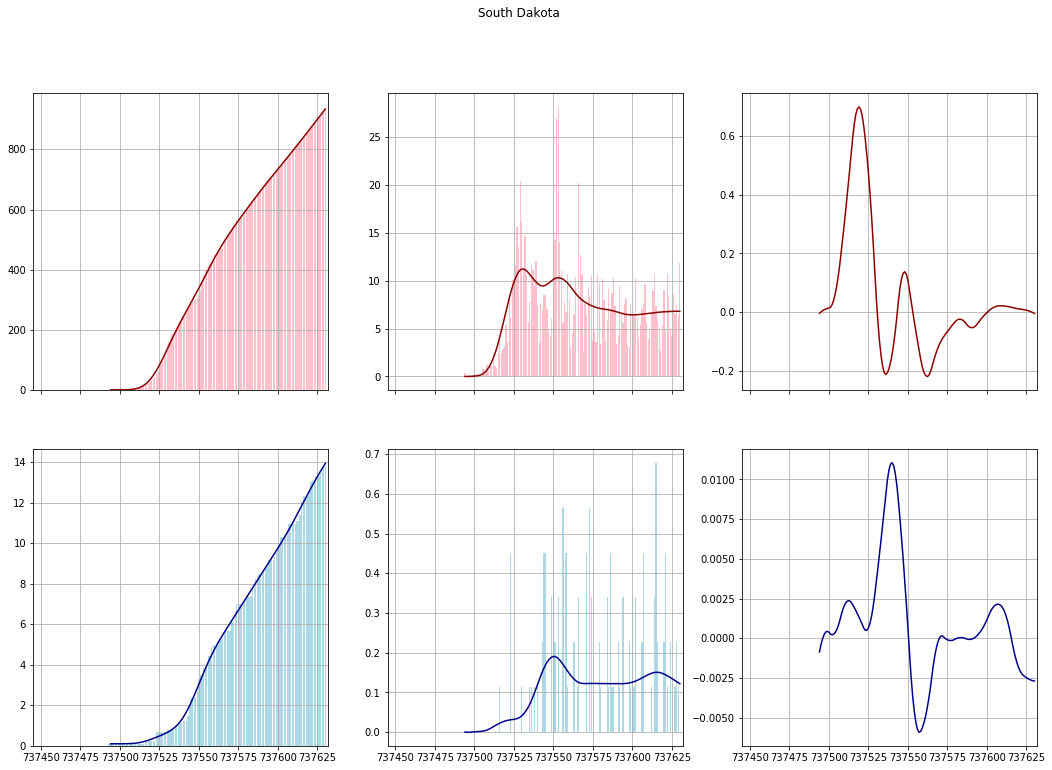

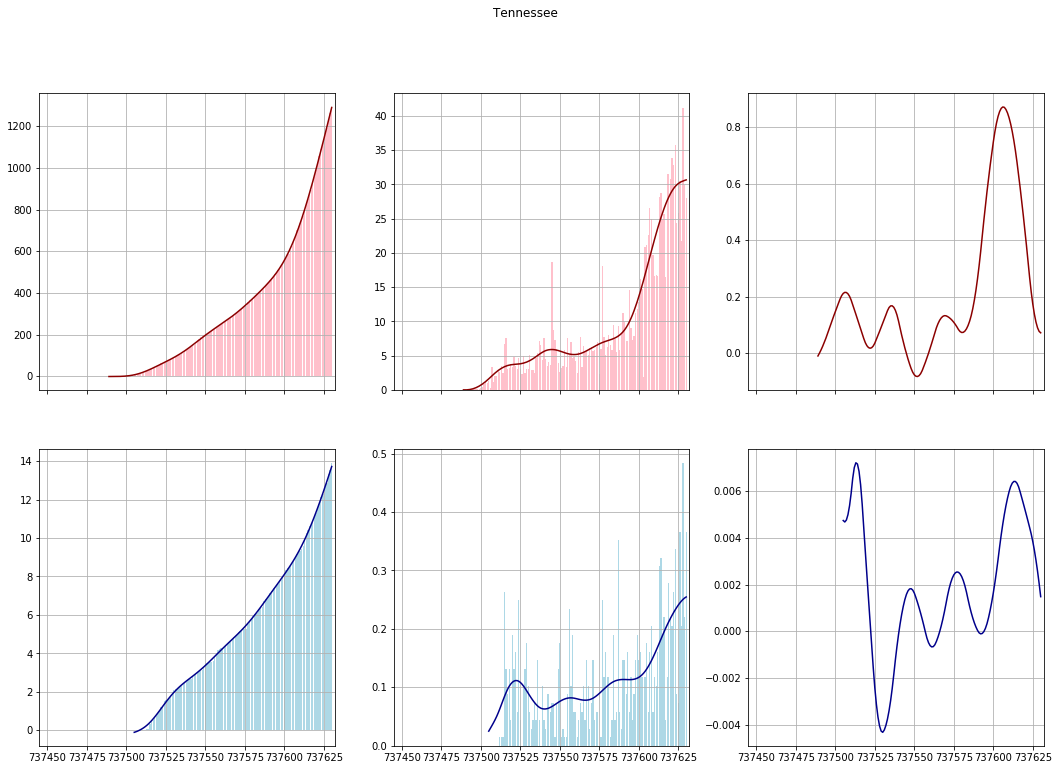

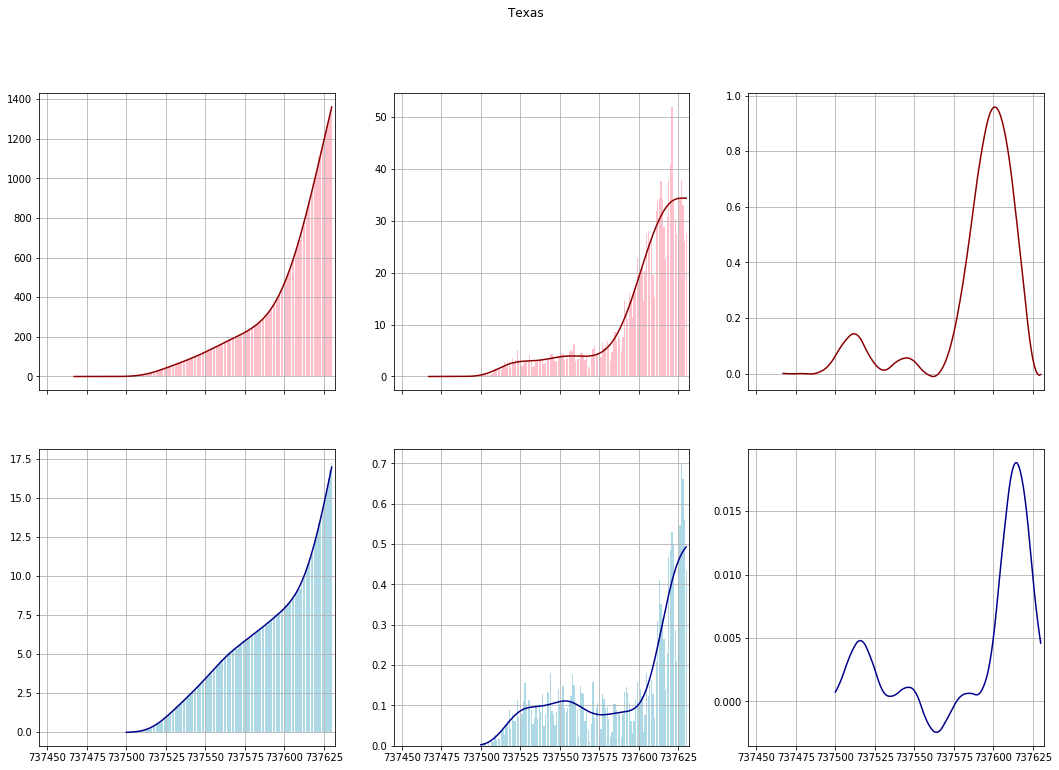

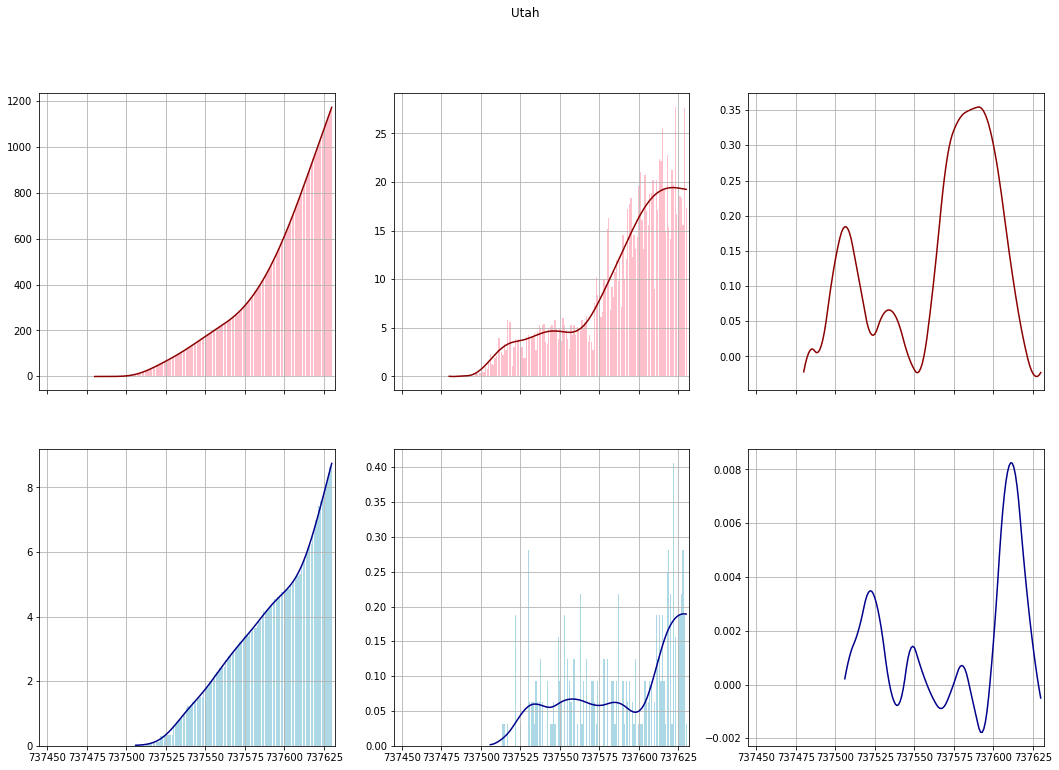

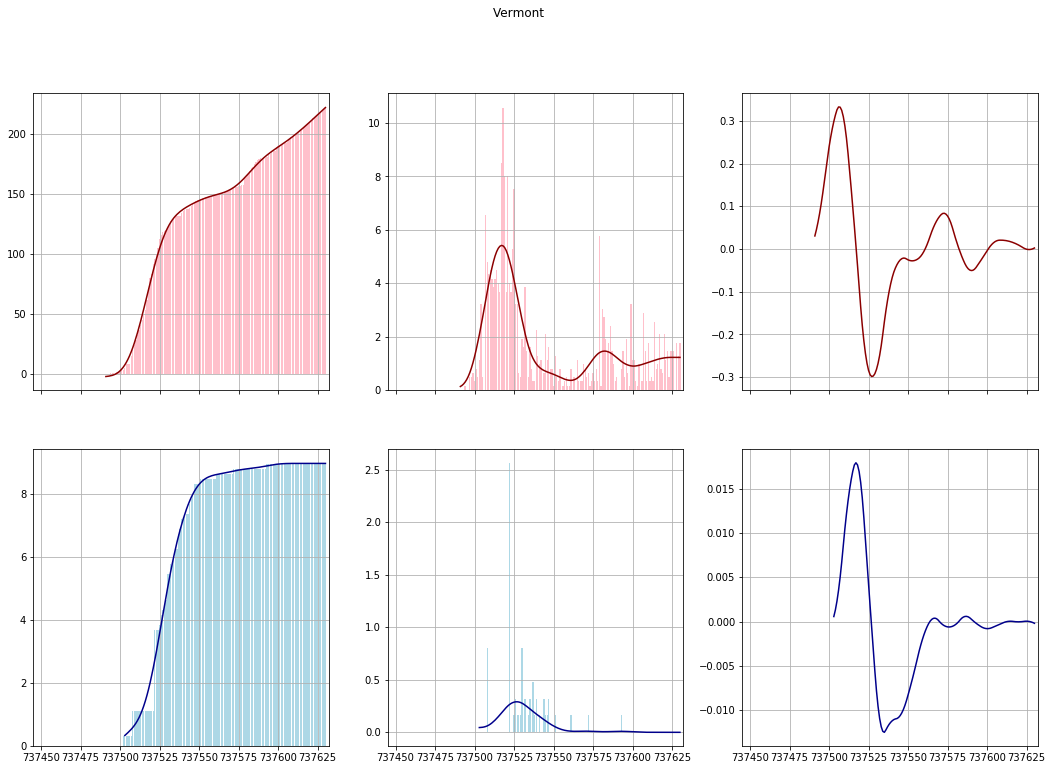

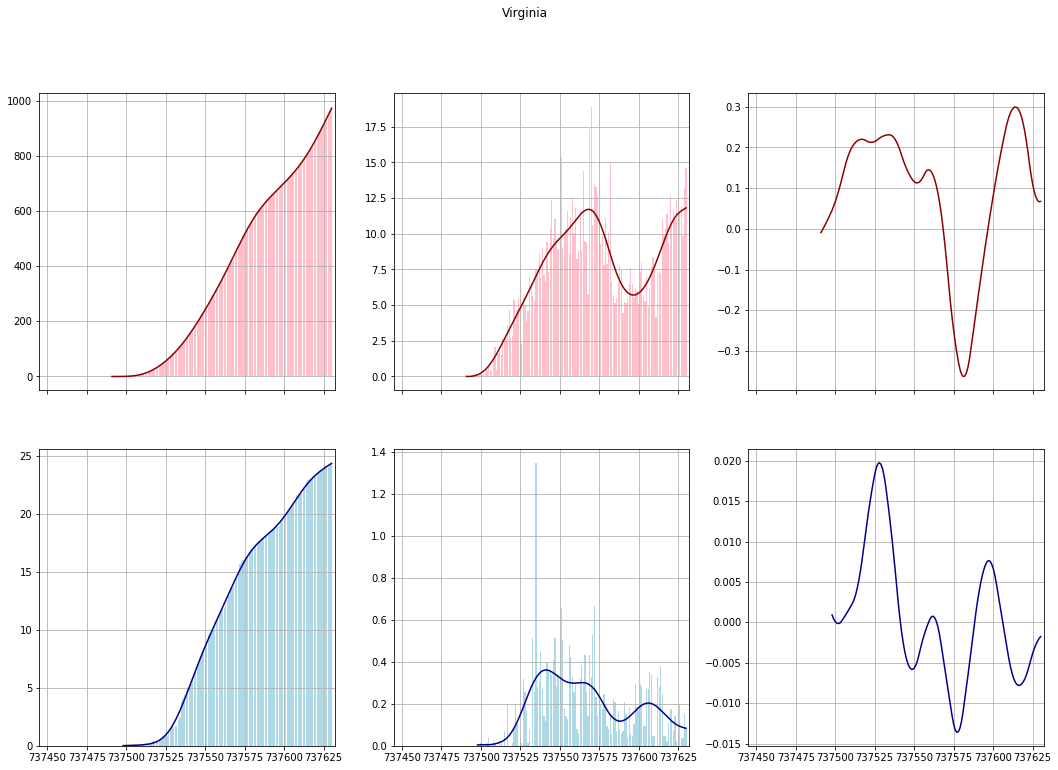

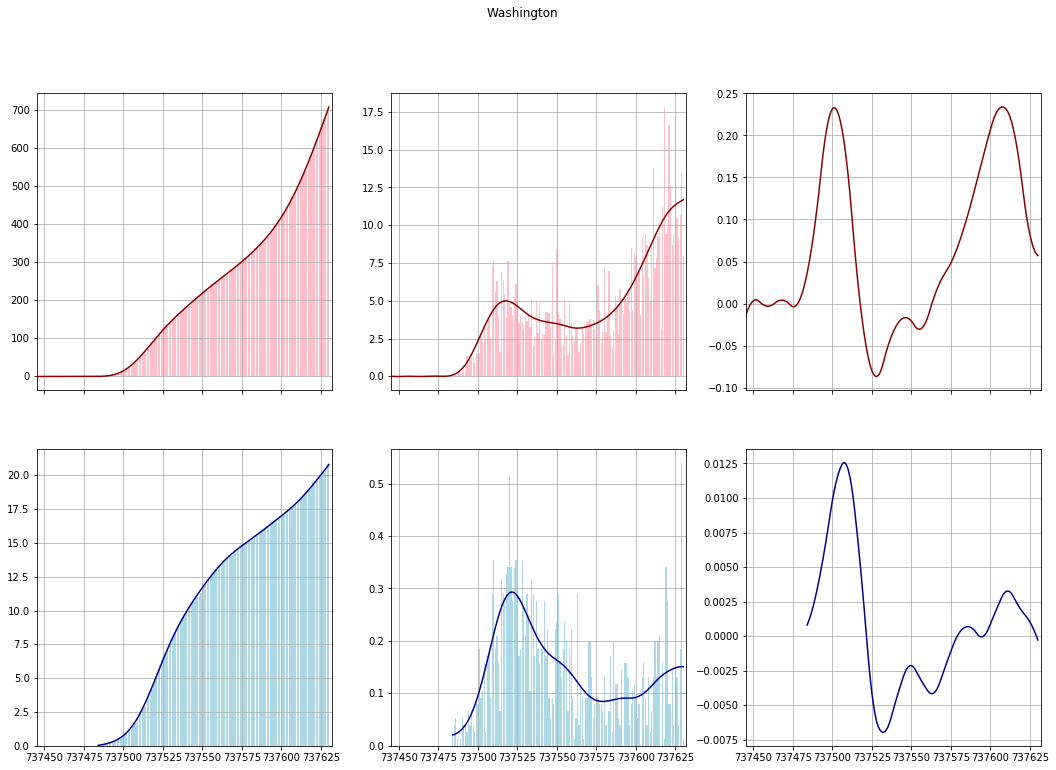

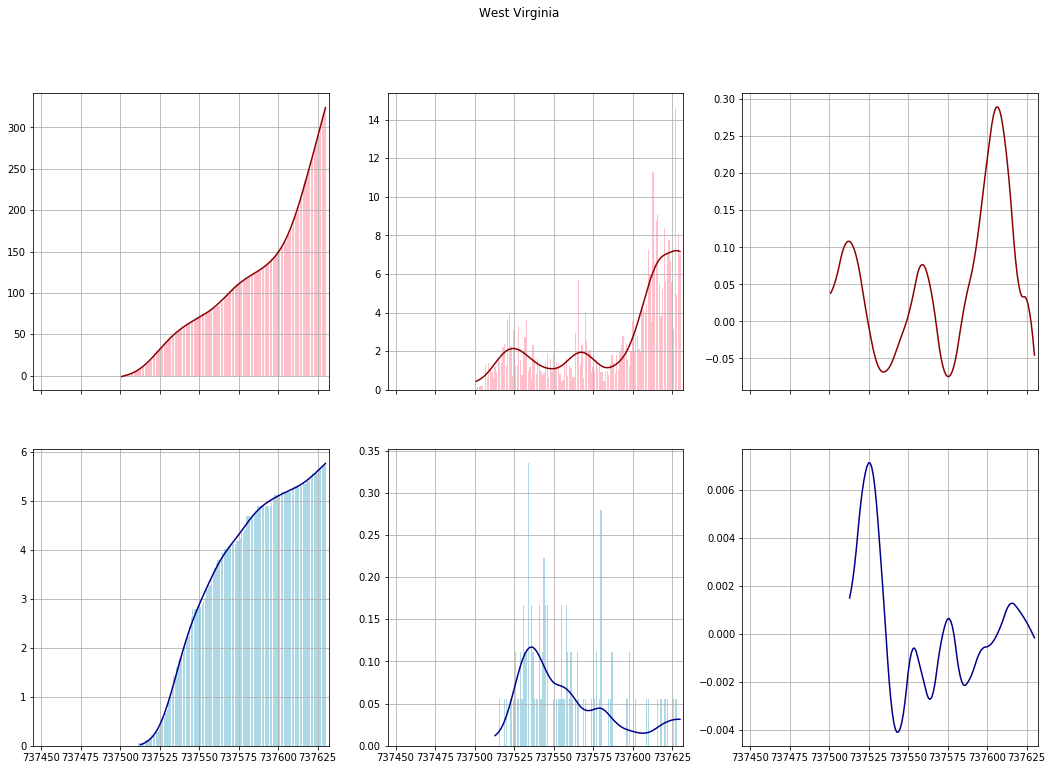

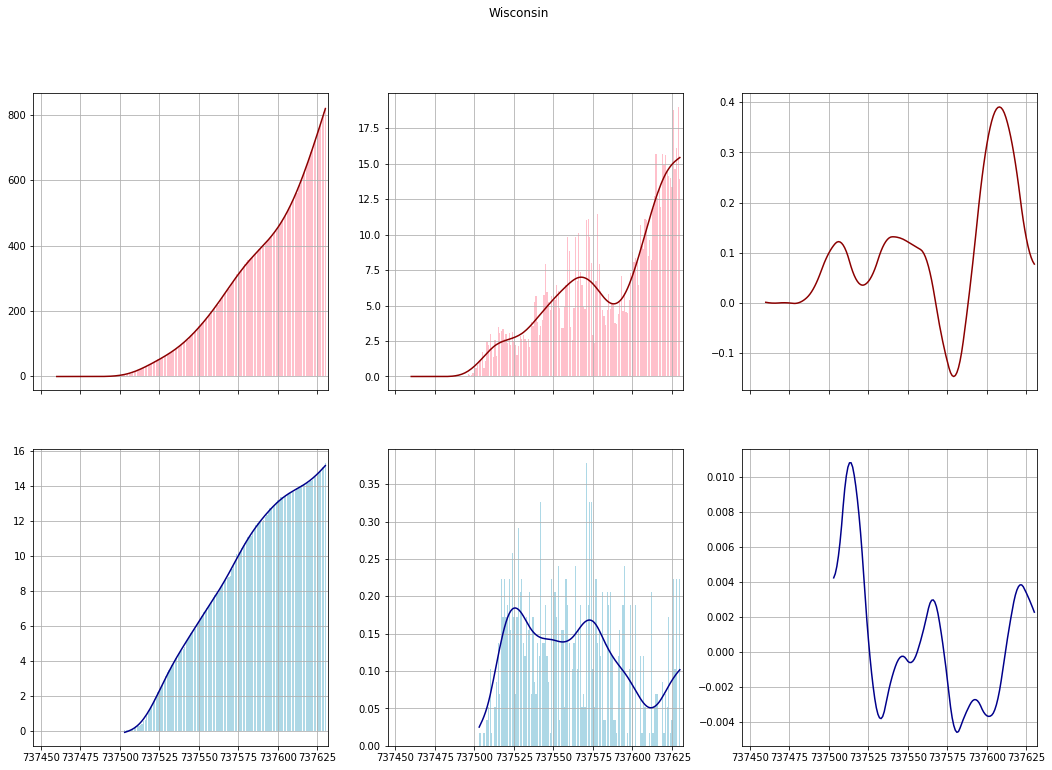

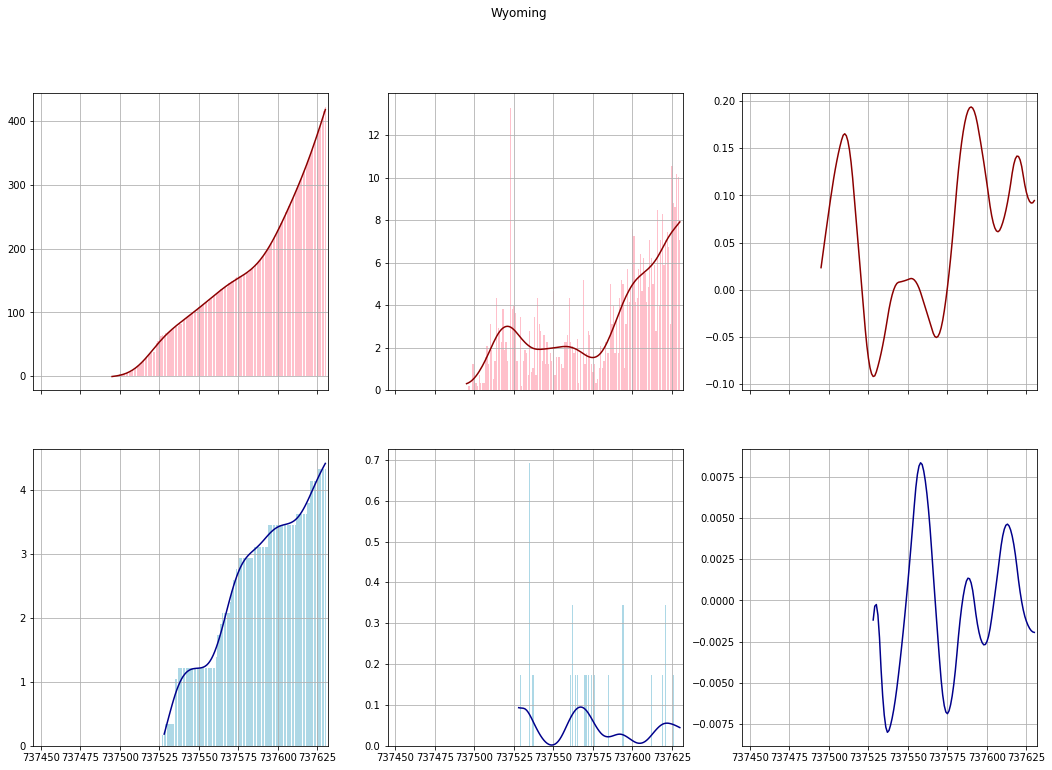

In [25]:
def plot_feature_graphs():
    start_xlim = date.fromisoformat('2020-01-21').toordinal()
    end_xlim = date.today().toordinal()
    def build_single_state_feature_graphs(state_id, pdf):
        current_state_cases_stats = state_stats_cases_dict[state_id]
        if state_id in state_stats_deaths_dict:
            current_state_deaths_stats = state_stats_deaths_dict[state_id]
    
        fig, ((ax11, ax21, ax31), (ax12, ax22, ax32)) = (
            plt.subplots(2, 3, figsize=(18, 12), sharex=True))
        fig.suptitle(current_state_cases_stats['state_name'])
    
        ax11.bar(current_state_cases_stats['base_vals'][:, 1], 
                 current_state_cases_stats['base_vals'][:, 2],
                 color='pink')
        ax11.plot(current_state_cases_stats['smoothed_vals'][:, 1], 
                  current_state_cases_stats['smoothed_vals'][:, 2],
                  color='darkred')
        ax11.set_xlim(start_xlim, end_xlim)
        ax11.grid()
        
        ax21.bar(current_state_cases_stats['base_diffs'][:, 1], 
                 current_state_cases_stats['base_diffs'][:, 2],
                 color='pink')
        ax21.plot(current_state_cases_stats['smoothed_diffs'][:, 1], 
                  current_state_cases_stats['smoothed_diffs'][:, 2],
                  color='darkred')
        ax21.set_xlim(start_xlim, end_xlim)
        ax21.grid()
    
        ax31.plot(current_state_cases_stats['smoothed_diff_derivs'][:, 1], 
                  current_state_cases_stats['smoothed_diff_derivs'][:, 2], 
                  color='darkred')
        ax31.set_xlim(start_xlim, end_xlim)
        ax31.grid()

        if state_id in state_stats_deaths_dict:
            ax12.bar(current_state_deaths_stats['base_vals'][:, 1],           
                     current_state_deaths_stats['base_vals'][:, 2], 
                     color='lightblue')
            ax12.plot(current_state_deaths_stats['smoothed_vals'][:, 1],
                      current_state_deaths_stats['smoothed_vals'][:, 2],
                      color='darkblue')
            ax12.grid()
            
            ax22.bar(current_state_deaths_stats['base_diffs'][:, 1], 
                     current_state_deaths_stats['base_diffs'][:, 2], 
                     color='lightblue')
            ax22.plot(current_state_deaths_stats['smoothed_diffs'][:, 1], 
                      current_state_deaths_stats['smoothed_diffs'][:, 2],
                      color='darkblue')
            ax22.grid()
            
            ax32.plot(current_state_deaths_stats['smoothed_diff_derivs'][:, 1], 
                      current_state_deaths_stats['smoothed_diff_derivs'][:, 2], 
                      color='darkblue')
            ax32.grid()
            
        pdf.savefig(fig)
        plt.show()
        plt.close()

        return None
    
    state_stats_cases_dict = build_state_stats_dict('normalized_cases')
    state_stats_deaths_dict = build_state_stats_dict('normalized_deaths')

    with PdfPages('state_stats_graph.pdf') as pdf:
        for state_id in state_stats_cases_dict:
            build_single_state_feature_graphs(state_id, pdf)

    return None

plot_feature_graphs()